# The code for generating the graphs 

## Note that some of the graphs maybe different than the ones in the document due to the random error that happens everytime we run the model. So some differences maybe alike but the final outcome is the same

In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import pandas as pd
import os

In [2]:
r_df = pd.read_csv("dataset/train.csv")

In [3]:
df = r_df.drop("Unnamed: 0", axis = 1).sample(frac=1)

In [4]:
df.head()

,filename,label,directory,width,height
26937,img_25698.jpg,6,dataset/trainingSet/trainingSet/6/img_25698.jpg,28,28
1973,img_2835.jpg,0,dataset/trainingSet/trainingSet/0/img_2835.jpg,28,28
41503,img_5586.jpg,9,dataset/trainingSet/trainingSet/9/img_5586.jpg,28,28
8341,img_6088.jpg,1,dataset/trainingSet/trainingSet/1/img_6088.jpg,28,28
25544,img_12914.jpg,6,dataset/trainingSet/trainingSet/6/img_12914.jpg,28,28


In [5]:
dummies = pd.get_dummies(df['label'])

In [6]:
new_df = pd.concat([df, dummies], axis = 1)

In [7]:
fraction = int(0.9 * len(df))
train_frac = int(0.9 * fraction)
train_df = new_df.iloc[:train_frac]
validation_df = new_df.iloc[train_frac:fraction]
test_df = new_df.iloc[fraction:]

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34020 entries, 26937 to 3265
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   34020 non-null  object
 1   label      34020 non-null  int64 
 2   directory  34020 non-null  object
 3   width      34020 non-null  int64 
 4   height     34020 non-null  int64 
 5   0          34020 non-null  uint8 
 6   1          34020 non-null  uint8 
 7   2          34020 non-null  uint8 
 8   3          34020 non-null  uint8 
 9   4          34020 non-null  uint8 
 10  5          34020 non-null  uint8 
 11  6          34020 non-null  uint8 
 12  7          34020 non-null  uint8 
 13  8          34020 non-null  uint8 
 14  9          34020 non-null  uint8 
dtypes: int64(3), object(2), uint8(10)
memory usage: 1.9+ MB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4200 entries, 19889 to 34915
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   4200 non-null   object
 1   label      4200 non-null   int64 
 2   directory  4200 non-null   object
 3   width      4200 non-null   int64 
 4   height     4200 non-null   int64 
 5   0          4200 non-null   uint8 
 6   1          4200 non-null   uint8 
 7   2          4200 non-null   uint8 
 8   3          4200 non-null   uint8 
 9   4          4200 non-null   uint8 
 10  5          4200 non-null   uint8 
 11  6          4200 non-null   uint8 
 12  7          4200 non-null   uint8 
 13  8          4200 non-null   uint8 
 14  9          4200 non-null   uint8 
dtypes: int64(3), object(2), uint8(10)
memory usage: 237.9+ KB


In [10]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
class single_layer:
    def __init__(self, train_df, valid_df, test_df, batch_size):
        self.train_df = train_df
        self.valid_df = valid_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.train_gen = self.train_gen = self.get_gen(self.train_df)
        self.valid_gen = self.get_gen(self.valid_df)
        self.test_gen = self.get_gen(self.test_df)
        self.model = Sequential()
        
        
        
    def get_gen(self, df):
        return ImageDataGenerator().flow_from_dataframe(
        dataframe = df,
        x_col = "directory",
        y_col = df.columns[5:],
        target_size = (28, 28),
        color_mode = "grayscale",
        class_mode = "raw",
        batch_size = self.batch_size,
        )
    
    def choose(self, item, learning_rate = 0.001):
        if item == "gradient":
            return tf.keras.optimizers.SGD(learning_rate = learning_rate)
        elif item == 'adam':
            return 'adam'
        elif item == 'binary_crossentropy':
            return 'binary_crossentropy'
        elif item == 'mean_squared_error':
            return tf.keras.losses.MeanSquaredError()

    def build_model(self, optimizer, loss, learning_rate = 0.001):
        self.model = Sequential([
            #Conv2D(32, (5,5), input_shape = (28, 28, 1)),
            #Conv2D(32, (5,5)),
            Flatten(input_shape = (28, 28)),
            #Dense(32, activation = 'relu'),
            Dense(10, activation = 'softmax')
        ])
        
        self.model.summary()
        self.model.compile(optimizer = self.choose(optimizer, learning_rate),
                     loss = self.choose(loss),
                     metrics = [tf.keras.metrics.MeanSquaredError(), 'accuracy'])
        
    
    def train_model(self, epochs):
        ssTrain = self.train_gen.n//self.batch_size
        ssValid = self.valid_gen.n//self.batch_size
        history = self.model.fit(
            self.train_gen,
            epochs = epochs,
            steps_per_epoch = ssTrain,
            validation_steps = ssValid,
            validation_data = self.valid_gen
        )
        return history
    

In [12]:
import matplotlib.pyplot as plt
def plot_with_epochs(lsts, labels, y_label, directory):
    j=0
    for lst in lsts:
        x = [i for i in range(1, len(lst) + 1)]
        plt.plot(x, lst, label = str(labels[j]))
        
        j += 1
    plt.xlabel('Epochs', fontsize = 16)
    plt.ylabel(y_label, fontsize = 16)
    plt.locator_params(axis="x", nbins=len(lst) + 1)
    plt.grid()
    plt.legend(prop = {'size' : 8})
    plt.savefig(directory, dpi = 1400)
    plt.show()

# Fixed learning rate (0.001), changing batch_size

In [29]:
b_full_histories = []
for j in range(5):
    print(f"""
    -----------------------------------------------------------------------------------------------
    ----------------------------------Iteration{j}-------------------------------------------------
    -----------------------------------------------------------------------------------------------
    """)
    histories = []
    for i in range(6):
        print(f"at batch size {4**i} with index {i}")
        model = single_layer(train_df, validation_df, test_df, 4**i)
        model.build_model('gradient', 'mean_squared_error', 0.001)
        temp = model.train_model(15)
        histories.append(temp)
    b_full_histories.append(histories)


    -----------------------------------------------------------------------------------------------
    ----------------------------------Iteration0-------------------------------------------------
    -----------------------------------------------------------------------------------------------
    
at batch size 1 with index 0
Found 34020 validated image filenames.
Found 3780 validated image filenames.
Found 4200 validated image filenames.
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_14 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


531/531 [==============================] - 8s 15ms/step - loss: 0.1620 - mean_squared_error: 0.1620 - accuracy: 0.1835 - val_loss: 0.1517 - val_mean_squared_error: 0.1517 - val_accuracy: 0.2357
Epoch 2/15
531/531 [==============================] - 7s 14ms/step - loss: 0.1484 - mean_squared_error: 0.1484 - accuracy: 0.2511 - val_loss: 0.1407 - val_mean_squared_error: 0.1407 - val_accuracy: 0.2910
Epoch 3/15
531/531 [==============================] - 8s 14ms/step - loss: 0.1368 - mean_squared_error: 0.1368 - accuracy: 0.3098 - val_loss: 0.1320 - val_mean_squared_error: 0.1320 - val_accuracy: 0.3342
Epoch 4/15
531/531 [==============================] - 8s 15ms/step - loss: 0.1288 - mean_squared_error: 0.1288 - accuracy: 0.3502 - val_loss: 0.1249 - val_mean_squared_error: 0.1249 - val_accuracy: 0.3697
Epoch 5/15
531/531 [==============================] - 8s 15ms/step - loss: 0.1230 - mean_squared_error: 0.1230 - accuracy: 0.3791 - val_loss: 0.1203 - val_mean_squared_error: 0.1203 - val_acc

Epoch 13/15
132/132 [==============================] - 7s 51ms/step - loss: 0.1575 - mean_squared_error: 0.1575 - accuracy: 0.2074 - val_loss: 0.1574 - val_mean_squared_error: 0.1574 - val_accuracy: 0.2070
Epoch 14/15
132/132 [==============================] - 7s 51ms/step - loss: 0.1554 - mean_squared_error: 0.1554 - accuracy: 0.2174 - val_loss: 0.1552 - val_mean_squared_error: 0.1552 - val_accuracy: 0.2182
Epoch 15/15
132/132 [==============================] - 7s 51ms/step - loss: 0.1529 - mean_squared_error: 0.1529 - accuracy: 0.2295 - val_loss: 0.1530 - val_mean_squared_error: 0.1530 - val_accuracy: 0.2294
at batch size 1024 with index 5
Found 34020 validated image filenames.
Found 3780 validated image filenames.
Found 4200 validated image filenames.
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
              

 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 784)               0         
                                                                 
 dense_22 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
2126/2126 [==============================] - 9s 4ms/step - loss: 0.1617 - mean_squared_error: 0.1617 - accuracy: 0.1851 - val_loss: 0.1452 - val_mean_squared_error: 0.1452 - val_accuracy: 0.2672
Epoch 2/15
2126/2126 [==============================] - 9s 4ms/step - loss: 0.1355 - mean_squared_error: 0.1355 - accuracy: 0.3174 - val_loss: 0.1217 - val_mean_squared_error: 0.1217 - val_accuracy: 0.3872
Epoch 3/15
2126/2126 [==============================] - 9s 4ms/step - loss: 0.1129 - mean_squared_error: 0.1129 - accuracy: 

531/531 [==============================] - 7s 14ms/step - loss: 0.1382 - mean_squared_error: 0.1382 - accuracy: 0.3030 - val_loss: 0.1344 - val_mean_squared_error: 0.1344 - val_accuracy: 0.3220
Epoch 9/15
531/531 [==============================] - 7s 14ms/step - loss: 0.1343 - mean_squared_error: 0.1343 - accuracy: 0.3228 - val_loss: 0.1310 - val_mean_squared_error: 0.1310 - val_accuracy: 0.3395
Epoch 10/15
531/531 [==============================] - 7s 14ms/step - loss: 0.1309 - mean_squared_error: 0.1309 - accuracy: 0.3398 - val_loss: 0.1276 - val_mean_squared_error: 0.1276 - val_accuracy: 0.3565
Epoch 11/15
531/531 [==============================] - 7s 14ms/step - loss: 0.1288 - mean_squared_error: 0.1288 - accuracy: 0.3506 - val_loss: 0.1250 - val_mean_squared_error: 0.1250 - val_accuracy: 0.3702
Epoch 12/15
531/531 [==============================] - 7s 14ms/step - loss: 0.1254 - mean_squared_error: 0.1254 - accuracy: 0.3673 - val_loss: 0.1216 - val_mean_squared_error: 0.1216 - val_

Epoch 13/15
34020/34020 [==============================] - 74s 2ms/step - loss: 0.1239 - mean_squared_error: 0.1239 - accuracy: 0.3801 - val_loss: 0.1219 - val_mean_squared_error: 0.1219 - val_accuracy: 0.3899
Epoch 14/15
34020/34020 [==============================] - 74s 2ms/step - loss: 0.1236 - mean_squared_error: 0.1236 - accuracy: 0.3812 - val_loss: 0.1212 - val_mean_squared_error: 0.1212 - val_accuracy: 0.3937
Epoch 15/15
34020/34020 [==============================] - 74s 2ms/step - loss: 0.1242 - mean_squared_error: 0.1242 - accuracy: 0.3784 - val_loss: 0.1208 - val_mean_squared_error: 0.1208 - val_accuracy: 0.3958
at batch size 4 with index 1
Found 34020 validated image filenames.
Found 3780 validated image filenames.
Found 4200 validated image filenames.
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_15 (Flatten)        (None, 784)               0         
     

Epoch 4/15
2126/2126 [==============================] - 9s 4ms/step - loss: 0.1249 - mean_squared_error: 0.1249 - accuracy: 0.3720 - val_loss: 0.1233 - val_mean_squared_error: 0.1233 - val_accuracy: 0.3798
Epoch 5/15
2126/2126 [==============================] - 9s 4ms/step - loss: 0.1206 - mean_squared_error: 0.1206 - accuracy: 0.3931 - val_loss: 0.1197 - val_mean_squared_error: 0.1197 - val_accuracy: 0.3978
Epoch 6/15
2126/2126 [==============================] - 9s 4ms/step - loss: 0.1173 - mean_squared_error: 0.1173 - accuracy: 0.4099 - val_loss: 0.1167 - val_mean_squared_error: 0.1167 - val_accuracy: 0.4129
Epoch 7/15
2126/2126 [==============================] - 9s 4ms/step - loss: 0.1107 - mean_squared_error: 0.1107 - accuracy: 0.4435 - val_loss: 0.1089 - val_mean_squared_error: 0.1089 - val_accuracy: 0.4523
Epoch 8/15
2126/2126 [==============================] - 9s 4ms/step - loss: 0.1048 - mean_squared_error: 0.1048 - accuracy: 0.4724 - val_loss: 0.1060 - val_mean_squared_error: 

Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
132/132 [==============================] - 7s 51ms/step - loss: 0.1806 - mean_squared_error: 0.1806 - accuracy: 0.0892 - val_loss: 0.1780 - val_mean_squared_error: 0.1780 - val_accuracy: 0.1024
Epoch 2/15
132/132 [==============================] - 7s 50ms/step - loss: 0.1785 - mean_squared_error: 0.1785 - accuracy: 0.1006 - val_loss: 0.1766 - val_mean_squared_error: 0.1766 - val_accuracy: 0.1105
Epoch 3/15
132/132 [==============================] - 7s 50ms/step - loss: 0.1769 - mean_squared_error: 0.1769 - accuracy: 0.1082 - val_loss: 0.1752 - val_mean_squared_error: 0.1752 - val_accuracy: 0.1164
Epoch 4/15
132/132 [==============================] - 7s 50ms/step - loss: 0.1747 - mean_squared_error: 0.1747 - accuracy: 0.1194 - val_loss: 0.1728 - val_mean_squared_error: 0.1728 - val_accuracy: 0.1275
Epoch 5/15
132/132 [==========================

8505/8505 [==============================] - 20s 2ms/step - loss: 0.1444 - mean_squared_error: 0.1444 - accuracy: 0.2728 - val_loss: 0.1133 - val_mean_squared_error: 0.1133 - val_accuracy: 0.4302
Epoch 2/15
8505/8505 [==============================] - 20s 2ms/step - loss: 0.0914 - mean_squared_error: 0.0914 - accuracy: 0.5400 - val_loss: 0.0803 - val_mean_squared_error: 0.0803 - val_accuracy: 0.5960
Epoch 3/15
8505/8505 [==============================] - 19s 2ms/step - loss: 0.0772 - mean_squared_error: 0.0772 - accuracy: 0.6115 - val_loss: 0.0732 - val_mean_squared_error: 0.0732 - val_accuracy: 0.6310
Epoch 4/15
8505/8505 [==============================] - 19s 2ms/step - loss: 0.0726 - mean_squared_error: 0.0726 - accuracy: 0.6349 - val_loss: 0.0699 - val_mean_squared_error: 0.0699 - val_accuracy: 0.6484
Epoch 5/15
8505/8505 [==============================] - 20s 2ms/step - loss: 0.0706 - mean_squared_error: 0.0706 - accuracy: 0.6456 - val_loss: 0.0687 - val_mean_squared_error: 0.0687

132/132 [==============================] - 7s 51ms/step - loss: 0.1465 - mean_squared_error: 0.1465 - accuracy: 0.2624 - val_loss: 0.1449 - val_mean_squared_error: 0.1449 - val_accuracy: 0.2712
Epoch 6/15
132/132 [==============================] - 7s 51ms/step - loss: 0.1445 - mean_squared_error: 0.1445 - accuracy: 0.2726 - val_loss: 0.1436 - val_mean_squared_error: 0.1436 - val_accuracy: 0.2768
Epoch 7/15
132/132 [==============================] - 7s 51ms/step - loss: 0.1430 - mean_squared_error: 0.1430 - accuracy: 0.2803 - val_loss: 0.1410 - val_mean_squared_error: 0.1410 - val_accuracy: 0.2907
Epoch 8/15
132/132 [==============================] - 7s 51ms/step - loss: 0.1420 - mean_squared_error: 0.1420 - accuracy: 0.2856 - val_loss: 0.1408 - val_mean_squared_error: 0.1408 - val_accuracy: 0.2921
Epoch 9/15
132/132 [==============================] - 7s 50ms/step - loss: 0.1411 - mean_squared_error: 0.1411 - accuracy: 0.2896 - val_loss: 0.1401 - val_mean_squared_error: 0.1401 - val_acc

Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
34020/34020 [==============================] - 71s 2ms/step - loss: 0.1373 - mean_squared_error: 0.1373 - accuracy: 0.3115 - val_loss: 0.1144 - val_mean_squared_error: 0.1144 - val_accuracy: 0.4267
Epoch 2/15
34020/34020 [==============================] - 70s 2ms/step - loss: 0.1140 - mean_squared_error: 0.1140 - accuracy: 0.4288 - val_loss: 0.1084 - val_mean_squared_error: 0.1084 - val_accuracy: 0.4566
Epoch 3/15
34020/34020 [==============================] - 70s 2ms/step - loss: 0.1113 - mean_squared_error: 0.1113 - accuracy: 0.4426 - val_loss: 0.1056 - val_mean_squared_error: 0.1056 - val_accuracy: 0.4714
Epoch 4/15
34020/34020 [==============================] - 72s 2ms/step - loss: 0.1089 - mean_squared_error: 0.1089 - accuracy: 0.4546 - val_loss: 0.1038 - val_mean_squared_error: 0.1038 - val_accuracy: 0.4799
Epoch 5/15
34020/34020 [======

Epoch 10/15
8505/8505 [==============================] - 19s 2ms/step - loss: 0.1092 - mean_squared_error: 0.1092 - accuracy: 0.4521 - val_loss: 0.1095 - val_mean_squared_error: 0.1095 - val_accuracy: 0.4513
Epoch 11/15
8505/8505 [==============================] - 19s 2ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - accuracy: 0.4534 - val_loss: 0.1094 - val_mean_squared_error: 0.1094 - val_accuracy: 0.4519
Epoch 12/15
8505/8505 [==============================] - 19s 2ms/step - loss: 0.1094 - mean_squared_error: 0.1094 - accuracy: 0.4511 - val_loss: 0.1086 - val_mean_squared_error: 0.1086 - val_accuracy: 0.4556
Epoch 13/15
8505/8505 [==============================] - 19s 2ms/step - loss: 0.1082 - mean_squared_error: 0.1082 - accuracy: 0.4572 - val_loss: 0.1069 - val_mean_squared_error: 0.1069 - val_accuracy: 0.4635
Epoch 14/15
8505/8505 [==============================] - 19s 2ms/step - loss: 0.1042 - mean_squared_error: 0.1042 - accuracy: 0.4772 - val_loss: 0.0976 - val_mean_squar

531/531 [==============================] - 8s 14ms/step - loss: 0.1756 - mean_squared_error: 0.1756 - accuracy: 0.1152 - val_loss: 0.1725 - val_mean_squared_error: 0.1725 - val_accuracy: 0.1308
Epoch 2/15
531/531 [==============================] - 7s 14ms/step - loss: 0.1700 - mean_squared_error: 0.1700 - accuracy: 0.1432 - val_loss: 0.1669 - val_mean_squared_error: 0.1669 - val_accuracy: 0.1592
Epoch 3/15
531/531 [==============================] - 7s 14ms/step - loss: 0.1622 - mean_squared_error: 0.1622 - accuracy: 0.1822 - val_loss: 0.1575 - val_mean_squared_error: 0.1575 - val_accuracy: 0.2055
Epoch 4/15
531/531 [==============================] - 7s 14ms/step - loss: 0.1535 - mean_squared_error: 0.1535 - accuracy: 0.2261 - val_loss: 0.1494 - val_mean_squared_error: 0.1494 - val_accuracy: 0.2455
Epoch 5/15
531/531 [==============================] - 7s 14ms/step - loss: 0.1451 - mean_squared_error: 0.1451 - accuracy: 0.2690 - val_loss: 0.1420 - val_mean_squared_error: 0.1420 - val_acc

Found 4200 validated image filenames.
Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_31 (Flatten)        (None, 784)               0         
                                                                 
 dense_43 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
33/33 [==============================] - 7s 206ms/step - loss: 0.1711 - mean_squared_error: 0.1711 - accuracy: 0.1358 - val_loss: 0.1714 - val_mean_squared_error: 0.1714 - val_accuracy: 0.1348
Epoch 2/15
33/33 [==============================] - 6s 196ms/step - loss: 0.1696 - mean_squared_error: 0.1696 - accuracy: 0.1438 - val_loss: 0.1688 - val_mean_squared_error: 0.1688 - val_accuracy: 0.1488
E

In [74]:
b_losses = []
b_accuracy = []
batch_sizes = [4**i for i in range(6)]
for histories in b_full_histories:
    b_losses.append(np.array([history.history['val_loss'] for history in histories]))
    b_accuracy.append(np.array([history.history['val_accuracy'] for history in histories]))
    
total_b_loss = sum(b_losses)/len(b_full_histories)
total_b_accuracy = sum(b_accuracy)/len(b_full_histories)
b_labels = []
for batch_size in batch_sizes:
    b_labels.append(f"B_S {batch_size}")

In [75]:
b_training_df = pd.DataFrame()
#lr_training_df.insert(0, "Learning Rate", learning_rates, True)
i = 0
for item in total_b_loss:
    b_training_df.insert(i, str(batch_sizes[i]) + " loss", item, True)
    i+=1
j = 0
for item in total_b_accuracy:
    b_training_df.insert(i, str(batch_sizes[j]) + " accuracy", item, True)
    i += 1
    j += 1
b_training_df.to_csv("dataframes/changingBatchSize.csv")
b_training_df.head()
    
        
    

,1 loss,4 loss,16 loss,64 loss,256 loss,1024 loss,1 accuracy,4 accuracy,16 accuracy,64 accuracy,256 accuracy,1024 accuracy
0,0.142153,0.122917,0.150115,0.162763,0.177899,0.180328,0.288307,0.381746,0.244015,0.179290,0.104129,0.092188
1,0.130118,0.097804,0.129433,0.154127,0.173832,0.179463,0.348466,0.508466,0.348464,0.223464,0.124833,0.097005
2,0.125974,0.091790,0.117698,0.147328,0.170708,0.178756,0.369418,0.538783,0.407309,0.257839,0.140123,0.100000
3,0.122815,0.088204,0.108769,0.141501,0.168604,0.177261,0.384974,0.557090,0.452383,0.286600,0.150781,0.107487
4,0.122671,0.086798,0.104461,0.137089,0.166254,0.176580,0.385714,0.564392,0.473941,0.309905,0.162556,0.111133


In [76]:
b_training_df

,1 loss,4 loss,16 loss,64 loss,256 loss,1024 loss,1 accuracy,4 accuracy,16 accuracy,64 accuracy,256 accuracy,1024 accuracy
0,0.142153,0.122917,0.150115,0.162763,0.177899,0.180328,0.288307,0.381746,0.244015,0.179290,0.104129,0.092188
1,0.130118,0.097804,0.129433,0.154127,0.173832,0.179463,0.348466,0.508466,0.348464,0.223464,0.124833,0.097005
2,0.125974,0.091790,0.117698,0.147328,0.170708,0.178756,0.369418,0.538783,0.407309,0.257839,0.140123,0.100000
3,0.122815,0.088204,0.108769,0.141501,0.168604,0.177261,0.384974,0.557090,0.452383,0.286600,0.150781,0.107487
4,0.122671,0.086798,0.104461,0.137089,0.166254,0.176580,0.385714,0.564392,0.473941,0.309905,0.162556,0.111133
5,0.122582,0.085575,0.100211,0.133612,0.164276,0.174661,0.386349,0.570370,0.495074,0.326854,0.172433,0.120573
6,0.121044,0.086462,0.096370,0.129356,0.161705,0.174682,0.394021,0.566190,0.515148,0.348464,0.185714,0.120573
7,0.121190,0.083828,0.093024,0.125877,0.160008,0.173464,0.393386,0.579048,0.532203,0.365837,0.194308,0.126693
8,0.121187,0.083354,0.090446,0.123264,0.158134,0.172440,0.393545,0.581799,0.544756,0.379449,0.203739,0.131445
9,0.120327,0.084164,0.088292,0.120952,0.155992,0.171466,0.397831,0.577989,0.555508,0.390890,0.214118,0.136198


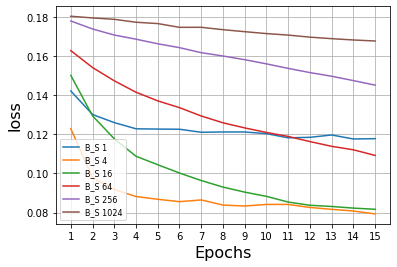

In [77]:
d = r"C:\Users\PC\Documents\projects\mathProject\figures\changing_batch_size.softmax\loss.png"
plot_with_epochs(total_b_loss, b_labels, "loss", d)

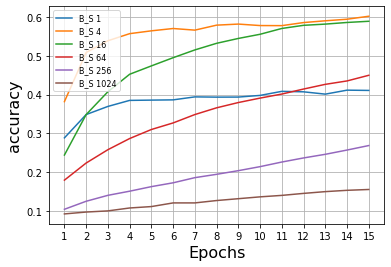

In [78]:
d = r"C:\Users\PC\Documents\projects\mathProject\figures\changing_batch_size.softmax\accuracy.png"
plot_with_epochs(total_b_accuracy, b_labels,"accuracy", d)

# Fixed Batch Size (32), Change Learning Rate

In [33]:
lr_full_histories = []
for j in range(5):
    print(f"""
    -----------------------------------------------------------------------------------------------
    ----------------------------------Iteration {j}-------------------------------------------------
    -----------------------------------------------------------------------------------------------
    """)
    histories = []
    for i in range(6):
        print(f"at learning rate {0.1/(4**i)} with index {i}")
        model = single_layer(train_df, validation_df, test_df, 32)
        model.build_model('gradient', 'mean_squared_error', 0.1/(4**i))
        temp = model.train_model(15)
        histories.append(temp)
    lr_full_histories.append(histories)


    -----------------------------------------------------------------------------------------------
    ----------------------------------Iteration 0-------------------------------------------------
    -----------------------------------------------------------------------------------------------
    
at learning rate 0.1 with index 0
Found 34020 validated image filenames.
Found 3780 validated image filenames.
Found 4200 validated image filenames.
Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_32 (Flatten)        (None, 784)               0         
                                                                 
 dense_44 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
___________________________________________________________

1063/1063 [==============================] - 8s 7ms/step - loss: 0.1745 - mean_squared_error: 0.1745 - accuracy: 0.1217 - val_loss: 0.1717 - val_mean_squared_error: 0.1717 - val_accuracy: 0.1364
Epoch 2/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1651 - mean_squared_error: 0.1651 - accuracy: 0.1703 - val_loss: 0.1625 - val_mean_squared_error: 0.1625 - val_accuracy: 0.1833
Epoch 3/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1563 - mean_squared_error: 0.1563 - accuracy: 0.2145 - val_loss: 0.1528 - val_mean_squared_error: 0.1528 - val_accuracy: 0.2317
Epoch 4/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1490 - mean_squared_error: 0.1490 - accuracy: 0.2516 - val_loss: 0.1506 - val_mean_squared_error: 0.1506 - val_accuracy: 0.2423
Epoch 5/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1468 - mean_squared_error: 0.1468 - accuracy: 0.2625 - val_loss: 0.1485 - val_mean_squared_error: 0.1485 - va

Epoch 2/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1803 - mean_squared_error: 0.1803 - accuracy: 0.0982 - val_loss: 0.1805 - val_mean_squared_error: 0.1805 - val_accuracy: 0.0977
Epoch 3/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1804 - mean_squared_error: 0.1804 - accuracy: 0.0982 - val_loss: 0.1805 - val_mean_squared_error: 0.1805 - val_accuracy: 0.0977
Epoch 4/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1803 - mean_squared_error: 0.1803 - accuracy: 0.0983 - val_loss: 0.1804 - val_mean_squared_error: 0.1804 - val_accuracy: 0.0980
Epoch 5/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1804 - mean_squared_error: 0.1804 - accuracy: 0.0982 - val_loss: 0.1804 - val_mean_squared_error: 0.1804 - val_accuracy: 0.0980
Epoch 6/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1804 - mean_squared_error: 0.1804 - accuracy: 0.0982 - val_loss: 0.1805 - val_mean_squared_error: 

 flatten_40 (Flatten)        (None, 784)               0         
                                                                 
 dense_52 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1363 - mean_squared_error: 0.1363 - accuracy: 0.3136 - val_loss: 0.1040 - val_mean_squared_error: 0.1040 - val_accuracy: 0.4775
Epoch 2/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.0973 - mean_squared_error: 0.0973 - accuracy: 0.5105 - val_loss: 0.0926 - val_mean_squared_error: 0.0926 - val_accuracy: 0.5342
Epoch 3/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.0885 - mean_squared_error: 0.0885 - accuracy: 0.5549 - val_loss: 0.0876 - val_mean_squared_error: 0.0876 - val_a

1063/1063 [==============================] - 8s 7ms/step - loss: 0.1820 - mean_squared_error: 0.1820 - accuracy: 0.0819 - val_loss: 0.1814 - val_mean_squared_error: 0.1814 - val_accuracy: 0.0847
Epoch 2/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1801 - mean_squared_error: 0.1801 - accuracy: 0.0913 - val_loss: 0.1788 - val_mean_squared_error: 0.1788 - val_accuracy: 0.0969
Epoch 3/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1779 - mean_squared_error: 0.1779 - accuracy: 0.1027 - val_loss: 0.1764 - val_mean_squared_error: 0.1764 - val_accuracy: 0.1096
Epoch 4/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1751 - mean_squared_error: 0.1751 - accuracy: 0.1161 - val_loss: 0.1731 - val_mean_squared_error: 0.1731 - val_accuracy: 0.1255
Epoch 5/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1717 - mean_squared_error: 0.1717 - accuracy: 0.1336 - val_loss: 0.1691 - val_mean_squared_error: 0.1691 - va

Epoch 13/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1777 - mean_squared_error: 0.1777 - accuracy: 0.1116 - val_loss: 0.1777 - val_mean_squared_error: 0.1777 - val_accuracy: 0.1115
Epoch 14/15
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1777 - mean_squared_error: 0.1777 - accuracy: 0.1116 - val_loss: 0.1776 - val_mean_squared_error: 0.1776 - val_accuracy: 0.1120
Epoch 15/15
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1777 - mean_squared_error: 0.1777 - accuracy: 0.1116 - val_loss: 0.1776 - val_mean_squared_error: 0.1776 - val_accuracy: 0.1120
at learning rate 0.025 with index 1
Found 34020 validated image filenames.
Found 3780 validated image filenames.
Found 4200 validated image filenames.
Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_45 (Flatten)        (None, 784)               0         
       

Epoch 4/15
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0911 - mean_squared_error: 0.0911 - accuracy: 0.5425 - val_loss: 0.0864 - val_mean_squared_error: 0.0864 - val_accuracy: 0.5657
Epoch 5/15
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0866 - mean_squared_error: 0.0866 - accuracy: 0.5648 - val_loss: 0.0844 - val_mean_squared_error: 0.0844 - val_accuracy: 0.5757
Epoch 6/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.0834 - mean_squared_error: 0.0834 - accuracy: 0.5807 - val_loss: 0.0777 - val_mean_squared_error: 0.0777 - val_accuracy: 0.6096
Epoch 7/15
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0795 - mean_squared_error: 0.0795 - accuracy: 0.6007 - val_loss: 0.0754 - val_mean_squared_error: 0.0754 - val_accuracy: 0.6218
Epoch 8/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.0772 - mean_squared_error: 0.0772 - accuracy: 0.6121 - val_loss: 0.0750 - val_mean_squared_error: 

Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1730 - mean_squared_error: 0.1730 - accuracy: 0.1279 - val_loss: 0.1686 - val_mean_squared_error: 0.1686 - val_accuracy: 0.1496
Epoch 2/15
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1646 - mean_squared_error: 0.1646 - accuracy: 0.1701 - val_loss: 0.1618 - val_mean_squared_error: 0.1618 - val_accuracy: 0.1841
Epoch 3/15
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1590 - mean_squared_error: 0.1590 - accuracy: 0.1988 - val_loss: 0.1575 - val_mean_squared_error: 0.1575 - val_accuracy: 0.2063
Epoch 4/15
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1550 - mean_squared_error: 0.1550 - accuracy: 0.2190 - val_loss: 0.1542 - val_mean_squared_error: 0.1542 - val_accuracy: 0.2240
Epoch 5/15
1063/1063 [====================

1063/1063 [==============================] - 8s 8ms/step - loss: 0.1745 - mean_squared_error: 0.1745 - accuracy: 0.1270 - val_loss: 0.1667 - val_mean_squared_error: 0.1667 - val_accuracy: 0.1650
Epoch 2/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1654 - mean_squared_error: 0.1654 - accuracy: 0.1720 - val_loss: 0.1647 - val_mean_squared_error: 0.1647 - val_accuracy: 0.1753
Epoch 3/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1648 - mean_squared_error: 0.1648 - accuracy: 0.1751 - val_loss: 0.1652 - val_mean_squared_error: 0.1652 - val_accuracy: 0.1732
Epoch 4/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1644 - mean_squared_error: 0.1644 - accuracy: 0.1774 - val_loss: 0.1666 - val_mean_squared_error: 0.1666 - val_accuracy: 0.1666
Epoch 5/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1653 - mean_squared_error: 0.1653 - accuracy: 0.1729 - val_loss: 0.1644 - val_mean_squared_error: 0.1644 - va

Epoch 5/15
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1389 - mean_squared_error: 0.1389 - accuracy: 0.2997 - val_loss: 0.1355 - val_mean_squared_error: 0.1355 - val_accuracy: 0.3162
Epoch 6/15
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1340 - mean_squared_error: 0.1340 - accuracy: 0.3246 - val_loss: 0.1304 - val_mean_squared_error: 0.1304 - val_accuracy: 0.3424
Epoch 7/15
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1281 - mean_squared_error: 0.1281 - accuracy: 0.3536 - val_loss: 0.1263 - val_mean_squared_error: 0.1263 - val_accuracy: 0.3641
Epoch 8/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1240 - mean_squared_error: 0.1240 - accuracy: 0.3742 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - val_accuracy: 0.3864
Epoch 9/15
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1206 - mean_squared_error: 0.1206 - accuracy: 0.3920 - val_loss: 0.1184 - val_mean_squared_error: 

                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1728 - mean_squared_error: 0.1728 - accuracy: 0.1357 - val_loss: 0.1627 - val_mean_squared_error: 0.1627 - val_accuracy: 0.1864
Epoch 2/15
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1625 - mean_squared_error: 0.1625 - accuracy: 0.1874 - val_loss: 0.1665 - val_mean_squared_error: 0.1665 - val_accuracy: 0.1674
Epoch 3/15
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1618 - mean_squared_error: 0.1618 - accuracy: 0.1908 - val_loss: 0.1578 - val_mean_squared_error: 0.1578 - val_accuracy: 0.2108
Epoch 4/15
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1608 - mean_squared_error: 0.1608 - accuracy: 0.1957 - val_loss: 0.1607 - val_mean_squared_error: 0.1607

1063/1063 [==============================] - 8s 8ms/step - loss: 0.1505 - mean_squared_error: 0.1505 - accuracy: 0.2413 - val_loss: 0.1345 - val_mean_squared_error: 0.1345 - val_accuracy: 0.3226
Epoch 2/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1296 - mean_squared_error: 0.1296 - accuracy: 0.3478 - val_loss: 0.1242 - val_mean_squared_error: 0.1242 - val_accuracy: 0.3739
Epoch 3/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1180 - mean_squared_error: 0.1180 - accuracy: 0.4058 - val_loss: 0.1136 - val_mean_squared_error: 0.1136 - val_accuracy: 0.4285
Epoch 4/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1068 - mean_squared_error: 0.1068 - accuracy: 0.4617 - val_loss: 0.0974 - val_mean_squared_error: 0.0974 - val_accuracy: 0.5079
Epoch 5/15
1063/1063 [==============================] - 8s 7ms/step - loss: 0.0915 - mean_squared_error: 0.0915 - accuracy: 0.5385 - val_loss: 0.0823 - val_mean_squared_error: 0.0823 - va

Found 4200 validated image filenames.
Model: "sequential_123"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_61 (Flatten)        (None, 784)               0         
                                                                 
 dense_73 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1063/1063 [==============================] - 9s 8ms/step - loss: 0.1877 - mean_squared_error: 0.1877 - accuracy: 0.0540 - val_loss: 0.1863 - val_mean_squared_error: 0.1863 - val_accuracy: 0.0612
Epoch 2/15
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1850 - mean_squared_error: 0.1850 - accuracy: 0.0668 - val_loss: 0.1833 - val_mean_squared_error: 0.1833 - val_accuracy: 0.0

In [34]:
lr_losses = []
lr_accuracy = []
learning_rates = [0.1/(4**i) for i in range(6)]
for histories in lr_full_histories:
    lr_losses.append(np.array([history.history['val_loss'] for history in histories]))
    lr_accuracy.append(np.array([history.history['val_accuracy'] for history in histories]))
    
lr_labels = []
total_lr_loss = sum(lr_losses)/len(lr_full_histories)
total_lr_accuracy = sum(lr_accuracy)/len(lr_full_histories)
for learning_rate in learning_rates:
    lr_labels.append(f"L_R {learning_rate}")

In [59]:
lr_training_df = pd.DataFrame()
#lr_training_df.insert(0, "Learning Rate", learning_rates, True)
i = 0
for item in total_lr_loss:
    lr_training_df.insert(i, str(learning_rates[i]) + " loss", item, True)
    i+=1
j = 0
for item in total_lr_accuracy:
    lr_training_df.insert(i, str(learning_rates[j]) + " accuracy", item, True)
    i += 1
    j += 1
lr_training_df.to_csv("dataframes/changingLearningRate.csv")
lr_training_df.head()

    
        
    

,0.1 loss,0.025 loss,0.00625 loss,0.0015625 loss,0.000390625 loss,9.765625e-05 loss,0.1 accuracy,0.025 accuracy,0.00625 accuracy,0.0015625 accuracy,0.000390625 accuracy,9.765625e-05 accuracy
0,0.169612,0.142524,0.126206,0.153149,0.167868,0.176327,0.151748,0.285805,0.365519,0.228549,0.154290,0.111441
1,0.166700,0.131725,0.106164,0.140447,0.161115,0.173249,0.166419,0.340201,0.466049,0.293061,0.188347,0.126748
2,0.163692,0.131158,0.097955,0.130963,0.155616,0.170432,0.181356,0.343114,0.507309,0.340996,0.216367,0.141314
3,0.164466,0.131135,0.095135,0.121692,0.151183,0.167789,0.177595,0.343485,0.521981,0.386970,0.238612,0.154184
4,0.163948,0.129667,0.090791,0.114397,0.146241,0.164581,0.180138,0.350847,0.543485,0.424153,0.263189,0.169597


In [57]:
lr_training_df

,0.1 loss,0.025 loss,0.00625 loss,0.0015625 loss,0.000390625 loss,9.765625e-05 loss,0.1 accuracy,0.025 accuracy,0.00625 accuracy,0.0015625 accuracy,0.000390625 accuracy,9.765625e-05 accuracy
0,0.169612,0.142524,0.126206,0.153149,0.167868,0.176327,0.151748,0.285805,0.365519,0.228549,0.154290,0.111441
1,0.166700,0.131725,0.106164,0.140447,0.161115,0.173249,0.166419,0.340201,0.466049,0.293061,0.188347,0.126748
2,0.163692,0.131158,0.097955,0.130963,0.155616,0.170432,0.181356,0.343114,0.507309,0.340996,0.216367,0.141314
3,0.164466,0.131135,0.095135,0.121692,0.151183,0.167789,0.177595,0.343485,0.521981,0.386970,0.238612,0.154184
4,0.163948,0.129667,0.090791,0.114397,0.146241,0.164581,0.180138,0.350847,0.543485,0.424153,0.263189,0.169597
5,0.160600,0.129009,0.086974,0.110088,0.141754,0.162522,0.196822,0.354078,0.562977,0.446239,0.286070,0.180561
6,0.162527,0.130328,0.085031,0.102562,0.138164,0.160422,0.187235,0.347458,0.573146,0.484004,0.304767,0.191419
7,0.162168,0.129633,0.083348,0.098099,0.134075,0.158669,0.189036,0.351006,0.581409,0.506091,0.325424,0.200318
8,0.160469,0.129421,0.081949,0.094943,0.130672,0.157158,0.197564,0.352013,0.588453,0.522352,0.341949,0.208051
9,0.162503,0.128887,0.082030,0.091112,0.127584,0.155675,0.187288,0.354873,0.588242,0.541367,0.357309,0.215307


In [46]:
lr_labels

['L_R 0.1',
 'L_R 0.025',
 'L_R 0.00625',
 'L_R 0.0015625',
 'L_R 0.000390625',
 'L_R 9.765625e-05']

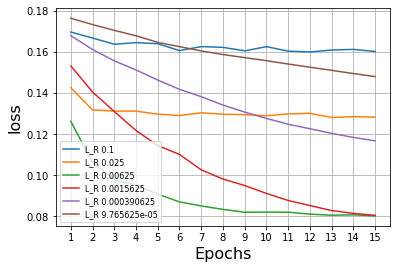

In [35]:
d = r"C:\Users\PC\Documents\projects\mathProject\figures\changing_learning_rate.softmax\loss.png"
plot_with_epochs(total_lr_loss, lr_labels, "loss", d)

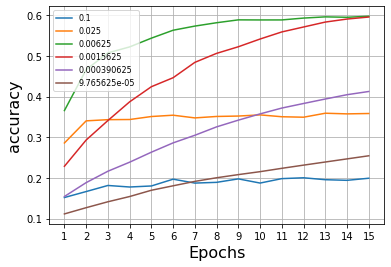

In [36]:
d = r"C:\Users\PC\Documents\projects\mathProject\figures\changing_learning_rate.softmax\accuracy.png"
plot_with_epochs(total_lr_accuracy, learning_rates,"accuracy", d)

In [63]:
import matplotlib.pyplot as plt
def plot_with_metric(x, y,metric, y_label, directory):
    plt.plot(x, y)
    plt.xlabel(metric, fontsize = 16)
    plt.ylabel(y_label, fontsize = 16)
    plt.xscale('log')
    plt.grid()
    plt.savefig(directory, dpi = 400)
    plt.show()

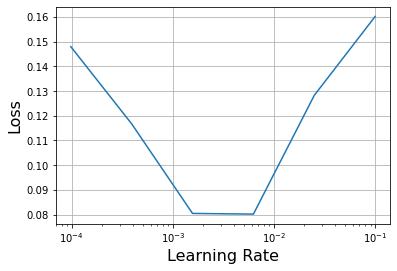

In [68]:
directory = r"C:\Users\PC\Documents\projects\mathProject\figures\changing_learning_rate.softmax\loss_metric.png"
plot_with_metric(learning_rates, lr_training_df.loc[14][:6], "Learning Rate", "Loss", directory)

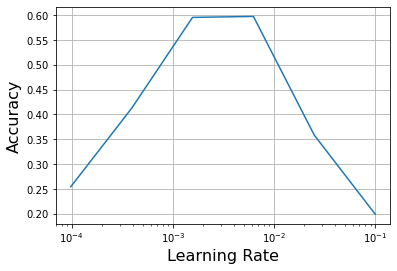

In [69]:
directory = r"C:\Users\PC\Documents\projects\mathProject\figures\changing_learning_rate.softmax\accuracy_metric.png"
plot_with_metric(learning_rates, lr_training_df.loc[14][6:], "Learning Rate", "Accuracy", directory)

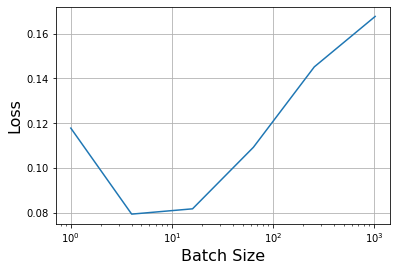

In [71]:
directory = r"C:\Users\PC\Documents\projects\mathProject\figures\changing_batch_size.softmax\loss_metric.png"
plot_with_metric(batch_sizes, b_training_df.loc[14][:6], "Batch Size", "Loss", directory)

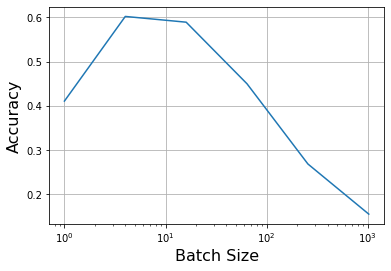

In [72]:
directory = r"C:\Users\PC\Documents\projects\mathProject\figures\changing_batch_size.softmax\accuracy_metric.png"
plot_with_metric(batch_sizes, b_training_df.loc[14][6:], "Batch Size", "Accuracy", directory)

# Testing out decay

In [110]:
class single_layer_mod:
    def __init__(self, train_df, valid_df, test_df, batch_size):
        self.train_df = train_df
        self.valid_df = valid_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.train_gen = self.train_gen = self.get_gen(self.train_df)
        self.valid_gen = self.get_gen(self.valid_df)
        self.test_gen = self.get_gen(self.test_df)
        self.model = Sequential()
        
        
        
    def get_gen(self, df):
        return ImageDataGenerator().flow_from_dataframe(
        dataframe = df,
        x_col = "directory",
        y_col = df.columns[5:],
        target_size = (28, 28),
        color_mode = "grayscale",
        class_mode = "raw",
        batch_size = self.batch_size,
        )
    
    def choose(self, item, learning_rate = 0.001, decay = 0.001):
        if item == "gradient":
            return tf.keras.optimizers.SGD(learning_rate = learning_rate, decay = decay)
        elif item == 'adam':
            return 'adam'
        elif item == 'binary_crossentropy':
            return 'binary_crossentropy'
        elif item == 'mean_squared_error':
            return tf.keras.losses.MeanSquaredError()

    def build_model(self, optimizer, loss, learning_rate = 0.001, decay = 0.001):
        self.model = Sequential([
            #Conv2D(32, (5,5), input_shape = (28, 28, 1)),
            #Conv2D(32, (5,5)),
            Flatten(input_shape = (28, 28)),
            #Dense(32, activation = 'relu'),
            Dense(10, activation = 'softmax')
        ])
        
        self.model.summary()
        self.model.compile(optimizer = self.choose(optimizer, learning_rate, decay),
                     loss = self.choose(loss),
                     metrics = [tf.keras.metrics.MeanSquaredError(), 'accuracy'])
        
    
    def train_model(self, epochs):
        ssTrain = self.train_gen.n//self.batch_size
        ssValid = self.valid_gen.n//self.batch_size
        history = self.model.fit(
            self.train_gen,
            epochs = epochs,
            steps_per_epoch = ssTrain,
            validation_steps = ssValid,
            validation_data = self.valid_gen
        )
        return history
    

In [112]:
no_decay_histories = []
for i in range(5):
    model = single_layer_mod(train_df, validation_df, test_df, 32)
    model.build_model("gradient", "mean_squared_error", 0.00316, 0)
    history = model.train_model(30)
    no_decay_histories.append(history)

Found 34020 validated image filenames.
Found 3780 validated image filenames.
Found 4200 validated image filenames.
Model: "sequential_159"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_79 (Flatten)        (None, 784)               0         
                                                                 
 dense_91 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1531 - mean_squared_error: 0.1531 - accuracy: 0.2290 - val_loss: 0.1375 - val_mean_squared_error: 0.1375 - val_accuracy: 0.3083
Epoch 2/30
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1282 - mean_squared_error: 0.1282 - accuracy: 0

Found 4200 validated image filenames.
Model: "sequential_161"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_80 (Flatten)        (None, 784)               0         
                                                                 
 dense_92 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1643 - mean_squared_error: 0.1643 - accuracy: 0.1741 - val_loss: 0.1453 - val_mean_squared_error: 0.1453 - val_accuracy: 0.2680
Epoch 2/30
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1293 - mean_squared_error: 0.1293 - accuracy: 0.3499 - val_loss: 0.1203 - val_mean_squared_error: 0.1203 - val_accuracy: 0.3

 Layer (type)                Output Shape              Param #   
 flatten_81 (Flatten)        (None, 784)               0         
                                                                 
 dense_93 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1542 - mean_squared_error: 0.1542 - accuracy: 0.2243 - val_loss: 0.1316 - val_mean_squared_error: 0.1316 - val_accuracy: 0.3374
Epoch 2/30
1063/1063 [==============================] - 9s 8ms/step - loss: 0.1212 - mean_squared_error: 0.1212 - accuracy: 0.3906 - val_loss: 0.1179 - val_mean_squared_error: 0.1179 - val_accuracy: 0.4062
Epoch 3/30
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1144 - mean_squared_error: 0.1144 - accuracy: 

 flatten_82 (Flatten)        (None, 784)               0         
                                                                 
 dense_94 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1505 - mean_squared_error: 0.1505 - accuracy: 0.2425 - val_loss: 0.1350 - val_mean_squared_error: 0.1350 - val_accuracy: 0.3207
Epoch 2/30
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1275 - mean_squared_error: 0.1275 - accuracy: 0.3582 - val_loss: 0.1243 - val_mean_squared_error: 0.1243 - val_accuracy: 0.3755
Epoch 3/30
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1147 - mean_squared_error: 0.1147 - accuracy: 0.4223 - val_loss: 0.1093 - val_mean_squared_error: 0.1093 - val_a

 dense_95 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1551 - mean_squared_error: 0.1551 - accuracy: 0.2196 - val_loss: 0.1386 - val_mean_squared_error: 0.1386 - val_accuracy: 0.3024
Epoch 2/30
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1294 - mean_squared_error: 0.1294 - accuracy: 0.3487 - val_loss: 0.1155 - val_mean_squared_error: 0.1155 - val_accuracy: 0.4187
Epoch 3/30
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1096 - mean_squared_error: 0.1096 - accuracy: 0.4485 - val_loss: 0.0960 - val_mean_squared_error: 0.0960 - val_accuracy: 0.5164
Epoch 4/30
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0870 - mean_squared_error: 0.0870 - ac

In [113]:
no_decay_loss = sum(np.array([val_loss.history['val_loss'] for val_loss in no_decay_histories]))/5
no_decay_accuracy = sum(np.array([val_accuracy.history['val_accuracy'] for val_accuracy in no_decay_histories]))/5

array([0.11978412, 0.09705236, 0.08462288, 0.07568192, 0.07245712,
       0.07045832, 0.06945181, 0.06815543, 0.06743175, 0.06728386,
       0.06644828, 0.06557862, 0.06579986, 0.06537412, 0.06475862])

In [128]:
yes_decay_histories = []
for i in range(5):
    model = single_layer_mod(train_df, validation_df, test_df, 32)
    model.build_model("gradient", "mean_squared_error", 0.0316, 0.1)
    history = model.train_model(30)
    yes_decay_histories.append(history)

Found 34020 validated image filenames.
Found 3780 validated image filenames.
Found 4200 validated image filenames.
Model: "sequential_201"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_100 (Flatten)       (None, 784)               0         
                                                                 
 dense_112 (Dense)           (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1530 - mean_squared_error: 0.1530 - accuracy: 0.2303 - val_loss: 0.1450 - val_mean_squared_error: 0.1450 - val_accuracy: 0.2704
Epoch 2/30
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1441 - mean_squared_error: 0.1441 - accuracy: 0

KeyboardInterrupt: 

In [125]:
yes_decay_loss = sum(np.array([val_loss.history['val_loss'] for val_loss in yes_decay_histories]))/5
yes_decay_accuracy = sum(np.array([val_accuracy.history['val_accuracy'] for val_accuracy in yes_decay_histories]))/5

In [103]:
decay_histories[5:]

In [126]:
yes_decay_loss

array([0.15371136, 0.15017594, 0.15046325, 0.1462963 , 0.14259235,
       0.14318102, 0.13986852, 0.13877112, 0.13915755, 0.13746041,
       0.13756436, 0.13932419, 0.1373304 , 0.13846831, 0.1377629 ,
       0.1387108 , 0.13690899, 0.13838225, 0.13780112, 0.13702306,
       0.13770445, 0.1364481 , 0.13648972, 0.13683999, 0.13693757,
       0.1364366 , 0.13684483, 0.13699924, 0.13736494, 0.13699076])

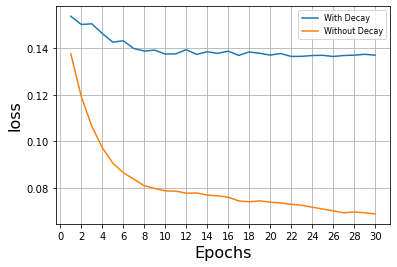

In [127]:
x = [i for i in range(1, 31)]
plt.plot(x, yes_decay_loss, label = "With Decay")
plt.plot(x, no_decay_loss, label = "Without Decay")
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('loss', fontsize = 16)
plt.locator_params(axis="x", nbins=31)
plt.grid()
plt.legend(prop = {'size' : 8})
directory = r"C:\Users\PC\Documents\projects\mathProject\figures\usingDecay\loss_high_learning_rate.png"
plt.savefig(directory, dpi = 1400)
plt.show()

# Multi Layered NN with a single hidden layer

In [13]:
class multi_layer:
    def __init__(self, train_df, valid_df, test_df, batch_size):
        self.train_df = train_df
        self.valid_df = valid_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.train_gen = self.train_gen = self.get_gen(self.train_df)
        self.valid_gen = self.get_gen(self.valid_df)
        self.test_gen = self.get_gen(self.test_df)
        self.model = Sequential()
        
        
        
    def get_gen(self, df):
        return ImageDataGenerator().flow_from_dataframe(
        dataframe = df,
        x_col = "directory",
        y_col = df.columns[5:],
        target_size = (28, 28),
        color_mode = "grayscale",
        class_mode = "raw",
        batch_size = self.batch_size,
        )
    
    def choose(self, item, learning_rate = 0.001):
        if item == "gradient":
            return tf.keras.optimizers.SGD(learning_rate = learning_rate)
        elif item == 'adam':
            return 'adam'
        elif item == 'binary_crossentropy':
            return 'binary_crossentropy'
        elif item == 'mean_squared_error':
            return tf.keras.losses.MeanSquaredError()

    def build_model(self, optimizer, loss, n, learning_rate = 0.001):
        self.model = Sequential([
            #Conv2D(32, (5,5), input_shape = (28, 28, 1)),
            #Conv2D(32, (5,5)),
            Flatten(input_shape = (28, 28)),
            Dense(128 - 32 * n, activation = 'relu'),
            Dense(10, activation = 'softmax')
        ])
        
        self.model.summary()
        self.model.compile(optimizer = self.choose(optimizer, learning_rate),
                     loss = self.choose(loss),
                     metrics = [tf.keras.metrics.MeanSquaredError(), 'accuracy'])
        
    
    def train_model(self, epochs):
        ssTrain = self.train_gen.n//self.batch_size
        ssValid = self.valid_gen.n//self.batch_size
        history = self.model.fit(
            self.train_gen,
            epochs = epochs,
            steps_per_epoch = ssTrain,
            validation_steps = ssValid,
            validation_data = self.valid_gen
        )
        return history
    

In [132]:
multi_layer_histories = []
for j in range(5):
    print(f"""
    -------------------------------------------------------------------------------------------------------------
    --------------------------------------------in iteration {i + 1} out of 5------------------------------------
    -------------------------------------------------------------------------------------------------------------
    """)
    histories = []
    for n in range(4):
        print(f"-------------------------------------------- the hidden layer is {128 - 32 * n} nodes------------------")
        model = multi_layer(train_df, validation_df, test_df, 32)
        model.build_model("gradient", "mean_squared_error", n, 0.00316)
        history = model.train_model(20)
        histories.append(history)
    multi_layer_histories.append(histories)


    -------------------------------------------------------------------------------------------------------------
    --------------------------------------------in iteration 1 out of 5------------------------------------
    -------------------------------------------------------------------------------------------------------------
    
-------------------------------------------- the hidden layer is 128 nodes------------------
Found 34020 validated image filenames.
Found 3780 validated image filenames.
Found 4200 validated image filenames.
Model: "sequential_204"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_101 (Flatten)       (None, 784)               0         
                                                                 
 dense_113 (Dense)           (None, 128)               100480    
                                                                 
 dense_114 (Dense)           (

1063/1063 [==============================] - 8s 8ms/step - loss: 0.1488 - mean_squared_error: 0.1488 - accuracy: 0.2492 - val_loss: 0.1334 - val_mean_squared_error: 0.1334 - val_accuracy: 0.3271
Epoch 2/20
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1232 - mean_squared_error: 0.1232 - accuracy: 0.3785 - val_loss: 0.1175 - val_mean_squared_error: 0.1175 - val_accuracy: 0.4078
Epoch 3/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1082 - mean_squared_error: 0.1082 - accuracy: 0.4537 - val_loss: 0.0981 - val_mean_squared_error: 0.0981 - val_accuracy: 0.5045
Epoch 4/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0899 - mean_squared_error: 0.0899 - accuracy: 0.5458 - val_loss: 0.0829 - val_mean_squared_error: 0.0829 - val_accuracy: 0.5805
Epoch 5/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0760 - mean_squared_error: 0.0760 - accuracy: 0.6153 - val_loss: 0.0703 - val_mean_squared_error: 0.0703 - va

1063/1063 [==============================] - 8s 8ms/step - loss: 0.0676 - mean_squared_error: 0.0676 - accuracy: 0.6587 - val_loss: 0.0673 - val_mean_squared_error: 0.0673 - val_accuracy: 0.6602
Epoch 18/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0674 - mean_squared_error: 0.0674 - accuracy: 0.6598 - val_loss: 0.0669 - val_mean_squared_error: 0.0669 - val_accuracy: 0.6626
Epoch 19/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0673 - mean_squared_error: 0.0673 - accuracy: 0.6603 - val_loss: 0.0671 - val_mean_squared_error: 0.0671 - val_accuracy: 0.6610
Epoch 20/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0668 - mean_squared_error: 0.0668 - accuracy: 0.6630 - val_loss: 0.0665 - val_mean_squared_error: 0.0665 - val_accuracy: 0.6637

    -------------------------------------------------------------------------------------------------------------
    --------------------------------------------in iteration 1 out of

                                                                 
Total params: 76,330
Trainable params: 76,330
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1063/1063 [==============================] - 9s 8ms/step - loss: 0.1350 - mean_squared_error: 0.1350 - accuracy: 0.3182 - val_loss: 0.1044 - val_mean_squared_error: 0.1044 - val_accuracy: 0.4717
Epoch 2/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0929 - mean_squared_error: 0.0929 - accuracy: 0.5304 - val_loss: 0.0777 - val_mean_squared_error: 0.0777 - val_accuracy: 0.6078
Epoch 3/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0742 - mean_squared_error: 0.0742 - accuracy: 0.6249 - val_loss: 0.0662 - val_mean_squared_error: 0.0662 - val_accuracy: 0.6650
Epoch 4/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0659 - mean_squared_error: 0.0659 - accuracy: 0.6670 - val_loss: 0.0615 - val_mean_squared_error: 0.06

1063/1063 [==============================] - 8s 8ms/step - loss: 0.0976 - mean_squared_error: 0.0976 - accuracy: 0.5065 - val_loss: 0.0975 - val_mean_squared_error: 0.0975 - val_accuracy: 0.5072
Epoch 13/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0970 - mean_squared_error: 0.0970 - accuracy: 0.5107 - val_loss: 0.0950 - val_mean_squared_error: 0.0950 - val_accuracy: 0.5180
Epoch 14/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0960 - mean_squared_error: 0.0960 - accuracy: 0.5154 - val_loss: 0.0945 - val_mean_squared_error: 0.0945 - val_accuracy: 0.5225
Epoch 15/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0956 - mean_squared_error: 0.0956 - accuracy: 0.5179 - val_loss: 0.0952 - val_mean_squared_error: 0.0952 - val_accuracy: 0.5199
Epoch 16/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0948 - mean_squared_error: 0.0948 - accuracy: 0.5217 - val_loss: 0.0945 - val_mean_squared_error: 0.0945 

Epoch 20/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1074 - mean_squared_error: 0.1074 - accuracy: 0.4607 - val_loss: 0.1070 - val_mean_squared_error: 0.1070 - val_accuracy: 0.4632
-------------------------------------------- the hidden layer is 96 nodes------------------
Found 34020 validated image filenames.
Found 3780 validated image filenames.
Found 4200 validated image filenames.
Model: "sequential_222"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_110 (Flatten)       (None, 784)               0         
                                                                 
 dense_131 (Dense)           (None, 96)                75360     
                                                                 
 dense_132 (Dense)           (None, 10)                970       
                                                                 
Total params: 76,330
Trainable par

1063/1063 [==============================] - 8s 8ms/step - loss: 0.1594 - mean_squared_error: 0.1594 - accuracy: 0.1960 - val_loss: 0.1460 - val_mean_squared_error: 0.1460 - val_accuracy: 0.2630
Epoch 2/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1328 - mean_squared_error: 0.1328 - accuracy: 0.3294 - val_loss: 0.1229 - val_mean_squared_error: 0.1229 - val_accuracy: 0.3795
Epoch 3/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1092 - mean_squared_error: 0.1092 - accuracy: 0.4478 - val_loss: 0.0973 - val_mean_squared_error: 0.0973 - val_accuracy: 0.5085
Epoch 4/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0842 - mean_squared_error: 0.0842 - accuracy: 0.5741 - val_loss: 0.0792 - val_mean_squared_error: 0.0792 - val_accuracy: 0.5985
Epoch 5/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0726 - mean_squared_error: 0.0726 - accuracy: 0.6326 - val_loss: 0.0706 - val_mean_squared_error: 0.0706 - va

Epoch 16/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0514 - mean_squared_error: 0.0514 - accuracy: 0.7410 - val_loss: 0.0494 - val_mean_squared_error: 0.0494 - val_accuracy: 0.7505
Epoch 17/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0509 - mean_squared_error: 0.0509 - accuracy: 0.7434 - val_loss: 0.0491 - val_mean_squared_error: 0.0491 - val_accuracy: 0.7529
Epoch 18/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0503 - mean_squared_error: 0.0503 - accuracy: 0.7465 - val_loss: 0.0496 - val_mean_squared_error: 0.0496 - val_accuracy: 0.7503
Epoch 19/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0505 - mean_squared_error: 0.0505 - accuracy: 0.7455 - val_loss: 0.0493 - val_mean_squared_error: 0.0493 - val_accuracy: 0.7519
Epoch 20/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0499 - mean_squared_error: 0.0499 - accuracy: 0.7481 - val_loss: 0.0494 - val_mean_squared_er

Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1381 - mean_squared_error: 0.1381 - accuracy: 0.3023 - val_loss: 0.1149 - val_mean_squared_error: 0.1149 - val_accuracy: 0.4182
Epoch 2/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1037 - mean_squared_error: 0.1037 - accuracy: 0.4753 - val_loss: 0.0939 - val_mean_squared_error: 0.0939 - val_accuracy: 0.5249
Epoch 3/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0817 - mean_squared_error: 0.0817 - accuracy: 0.5866 - val_loss: 0.0696 - val_mean_squared_error: 0.0696 - val_accuracy: 0.6480
Epoch 4/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0683 - mean_squared_error: 0.0683 - accuracy: 0.6540 - val_loss: 0.0650 - val_mean_squared_error: 0.0650 - val_accuracy: 0.6711
Epoch 5/20
1063/1063 [==================

Epoch 12/20
1063/1063 [==============================] - 9s 8ms/step - loss: 0.0506 - mean_squared_error: 0.0506 - accuracy: 0.7442 - val_loss: 0.0418 - val_mean_squared_error: 0.0418 - val_accuracy: 0.7879
Epoch 13/20
1063/1063 [==============================] - 9s 8ms/step - loss: 0.0380 - mean_squared_error: 0.0380 - accuracy: 0.8076 - val_loss: 0.0364 - val_mean_squared_error: 0.0364 - val_accuracy: 0.8159
Epoch 14/20
1063/1063 [==============================] - 9s 8ms/step - loss: 0.0358 - mean_squared_error: 0.0358 - accuracy: 0.8189 - val_loss: 0.0362 - val_mean_squared_error: 0.0362 - val_accuracy: 0.8165
Epoch 15/20
1063/1063 [==============================] - 9s 8ms/step - loss: 0.0350 - mean_squared_error: 0.0350 - accuracy: 0.8227 - val_loss: 0.0341 - val_mean_squared_error: 0.0341 - val_accuracy: 0.8276
Epoch 16/20
1063/1063 [==============================] - 9s 8ms/step - loss: 0.0336 - mean_squared_error: 0.0336 - accuracy: 0.8297 - val_loss: 0.0345 - val_mean_squared_er

Found 34020 validated image filenames.
Found 3780 validated image filenames.
Found 4200 validated image filenames.
Model: "sequential_240"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_119 (Flatten)       (None, 784)               0         
                                                                 
 dense_149 (Dense)           (None, 64)                50240     
                                                                 
 dense_150 (Dense)           (None, 10)                650       
                                                                 
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1063/1063 [==============================] - 9s 8ms/step - loss: 0.1405 - mean_squared_error: 0.1405 - accuracy: 0.2889 - val_loss: 0.1146 - val_mean_squared_error: 0.1146 - val_accuracy

1063/1063 [==============================] - 9s 8ms/step - loss: 0.1591 - mean_squared_error: 0.1591 - accuracy: 0.1997 - val_loss: 0.1548 - val_mean_squared_error: 0.1548 - val_accuracy: 0.2217
Epoch 2/20
1063/1063 [==============================] - 9s 8ms/step - loss: 0.1506 - mean_squared_error: 0.1506 - accuracy: 0.2432 - val_loss: 0.1495 - val_mean_squared_error: 0.1495 - val_accuracy: 0.2495
Epoch 3/20
1063/1063 [==============================] - 9s 8ms/step - loss: 0.1460 - mean_squared_error: 0.1460 - accuracy: 0.2662 - val_loss: 0.1423 - val_mean_squared_error: 0.1423 - val_accuracy: 0.2828
Epoch 4/20
1063/1063 [==============================] - 9s 8ms/step - loss: 0.1332 - mean_squared_error: 0.1332 - accuracy: 0.3291 - val_loss: 0.1250 - val_mean_squared_error: 0.1250 - val_accuracy: 0.3694
Epoch 5/20
1063/1063 [==============================] - 9s 8ms/step - loss: 0.1206 - mean_squared_error: 0.1206 - accuracy: 0.3921 - val_loss: 0.1186 - val_mean_squared_error: 0.1186 - va

In [133]:
multi_loss = []
multi_accuracy = []
nodes = [128 - 32*n for n in range(4)]
for histories in multi_layer_histories:
    multi_loss.append(np.array([history.history['val_loss'] for history in histories]))
    multi_accuracy.append(np.array([history.history['val_accuracy'] for history in histories]))
multi_layer_labels = []
tot_multi_loss = sum(multi_loss)/len(multi_layer_histories)
tot_multi_accuracy = sum(multi_accuracy)/len(multi_layer_histories)
for node in nodes:
    multi_layer_labels.append(f"{node} Node")
    

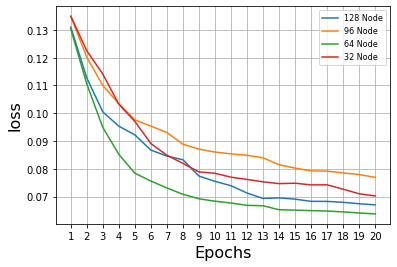

In [138]:
d = r"C:\Users\PC\Documents\projects\mathProject\figures\multi_layer\loss.png"
plot_with_epochs(tot_multi_loss, multi_layer_labels, "loss", d)

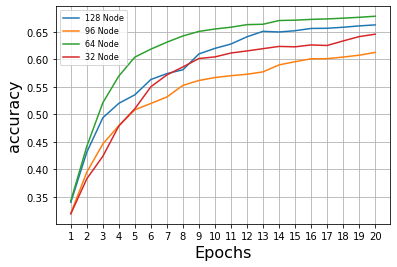

In [139]:
d = r"C:\Users\PC\Documents\projects\mathProject\figures\multi_layer\accuracy.png"
plot_with_epochs(tot_multi_accuracy, multi_layer_labels, "accuracy", d)

In [14]:
single_layer_histories = []
for n in range(5):
    print(f"--------------------------------------------Iteration {n}------------------")
    model = single_layer(train_df, validation_df, test_df, 32)
    model.build_model("gradient", "mean_squared_error", 0.00316)
    history = model.train_model(20)
    single_layer_histories.append(history)


--------------------------------------------Iteration 0------------------
Found 34020 validated image filenames.
Found 3780 validated image filenames.
Found 4200 validated image filenames.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1063/1063 [==============================] - 14s 11ms/step - loss: 0.1709 - mean_squared_error: 0.1709 - accuracy: 0.1410 - val_loss: 0.1653 - val_mean_squared_error: 0.1653 - val_accuracy: 0.1687
Epoch 2/20
1063/1063 [=============================

Epoch 2/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1183 - mean_squared_error: 0.1183 - accuracy: 0.4042 - val_loss: 0.1099 - val_mean_squared_error: 0.1099 - val_accuracy: 0.4465
Epoch 3/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1066 - mean_squared_error: 0.1066 - accuracy: 0.4636 - val_loss: 0.1012 - val_mean_squared_error: 0.1012 - val_accuracy: 0.4913
Epoch 4/20
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1011 - mean_squared_error: 0.1011 - accuracy: 0.4919 - val_loss: 0.0996 - val_mean_squared_error: 0.0996 - val_accuracy: 0.5000
Epoch 5/20
1063/1063 [==============================] - 8s 7ms/step - loss: 0.0987 - mean_squared_error: 0.0987 - accuracy: 0.5043 - val_loss: 0.0979 - val_mean_squared_error: 0.0979 - val_accuracy: 0.5079
Epoch 6/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0965 - mean_squared_error: 0.0965 - accuracy: 0.5151 - val_loss: 0.0950 - val_mean_squared_error: 

1063/1063 [==============================] - 8s 7ms/step - loss: 0.0602 - mean_squared_error: 0.0602 - accuracy: 0.6960 - val_loss: 0.0579 - val_mean_squared_error: 0.0579 - val_accuracy: 0.7071
Epoch 13/20
1063/1063 [==============================] - 8s 7ms/step - loss: 0.0592 - mean_squared_error: 0.0592 - accuracy: 0.7014 - val_loss: 0.0580 - val_mean_squared_error: 0.0580 - val_accuracy: 0.7066
Epoch 14/20
1063/1063 [==============================] - 8s 7ms/step - loss: 0.0588 - mean_squared_error: 0.0588 - accuracy: 0.7037 - val_loss: 0.0560 - val_mean_squared_error: 0.0560 - val_accuracy: 0.7182
Epoch 15/20
1063/1063 [==============================] - 8s 7ms/step - loss: 0.0581 - mean_squared_error: 0.0581 - accuracy: 0.7072 - val_loss: 0.0569 - val_mean_squared_error: 0.0569 - val_accuracy: 0.7140
Epoch 16/20
1063/1063 [==============================] - 8s 7ms/step - loss: 0.0578 - mean_squared_error: 0.0578 - accuracy: 0.7085 - val_loss: 0.0571 - val_mean_squared_error: 0.0571 

 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1578 - mean_squared_error: 0.1578 - accuracy: 0.2060 - val_loss: 0.1447 - val_mean_squared_error: 0.1447 - val_accuracy: 0.2720
Epoch 2/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1379 - mean_squared_error: 0.1379 - accuracy: 0.3068 - val_loss: 0.1337 - val_mean_squared_error: 0.1337 - val_accuracy: 0.3276
Epoch 3/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1317 - mean_squared_error: 0.1317 - accuracy: 

In [15]:
single_layer_loss = sum([np.array(history.history['val_loss']) for history in single_layer_histories])/5
single_layer_loss

array([0.13763485, 0.12047976, 0.11229549, 0.10545665, 0.1022873 ,
       0.09806039, 0.09237918, 0.0897491 , 0.08742778, 0.08645461,
       0.08550111, 0.08370187, 0.082523  , 0.08134038, 0.08092508,
       0.08097758, 0.08050568, 0.07696735, 0.07617982, 0.07529561])

In [16]:
single_layer_acc = sum([np.array(history.history['val_accuracy']) for history in single_layer_histories])/5
single_layer_acc

array([0.3070445 , 0.39369704, 0.43511652, 0.46917374, 0.48532839,
       0.50624999, 0.53522247, 0.54835805, 0.56038134, 0.56514829,
       0.56959747, 0.5787606 , 0.58474576, 0.59094279, 0.59353813,
       0.59269067, 0.59539195, 0.61297669, 0.61694914, 0.62086865])

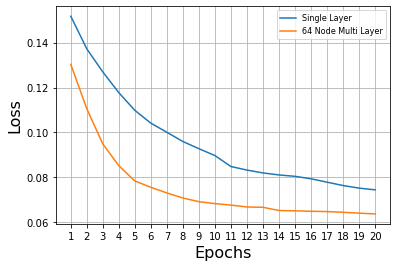

In [146]:
x = [i for i in range(1, 21)]
plt.plot(x, single_layer_loss, label = "Single Layer")
plt.plot(x, tot_multi_loss[2], label = "64 Node Multi Layer")
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel("Loss", fontsize = 16)
plt.locator_params(axis="x", nbins=21)
plt.grid()
plt.legend(prop = {'size' : 8})
directory = r"C:\Users\PC\Documents\projects\mathProject\figures\multi_layer\withsingle.png"
plt.savefig(directory, dpi = 1400)
plt.show()

In [17]:
class multi_layer_1:
    def __init__(self, train_df, valid_df, test_df, batch_size):
        self.train_df = train_df
        self.valid_df = valid_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.train_gen = self.train_gen = self.get_gen(self.train_df)
        self.valid_gen = self.get_gen(self.valid_df)
        self.test_gen = self.get_gen(self.test_df)
        self.model = Sequential()
        
        
        
    def get_gen(self, df):
        return ImageDataGenerator().flow_from_dataframe(
        dataframe = df,
        x_col = "directory",
        y_col = df.columns[5:],
        target_size = (28, 28),
        color_mode = "grayscale",
        class_mode = "raw",
        batch_size = self.batch_size,
        )
    
    def choose(self, item, learning_rate = 0.001):
        if item == "gradient":
            return tf.keras.optimizers.SGD(learning_rate = learning_rate)
        elif item == 'adam':
            return 'adam'
        elif item == 'binary_crossentropy':
            return 'binary_crossentropy'
        elif item == 'mean_squared_error':
            return tf.keras.losses.MeanSquaredError()

    def build_model(self, optimizer, loss, learning_rate = 0.001):
        self.model = Sequential([
            #Conv2D(32, (5,5), input_shape = (28, 28, 1)),
            #Conv2D(32, (5,5)),
            Flatten(input_shape = (28, 28)),
            Dense(64, activation = 'relu'),
            Dense(10, activation = 'softmax')
        ])
        
        self.model.summary()
        self.model.compile(optimizer = self.choose(optimizer, learning_rate),
                     loss = self.choose(loss),
                     metrics = [tf.keras.metrics.MeanSquaredError(), 'accuracy'])
        
    
    def train_model(self, epochs):
        ssTrain = self.train_gen.n//self.batch_size
        ssValid = self.valid_gen.n//self.batch_size
        history = self.model.fit(
            self.train_gen,
            epochs = epochs,
            steps_per_epoch = ssTrain,
            validation_steps = ssValid,
            validation_data = self.valid_gen
        )
        return history
    

In [18]:
multi_layer_1_histories = []
for n in range(5):
    print(f"--------------------------------------------iteration {n}------------------")
    model = multi_layer_1(train_df, validation_df, test_df, 32)
    model.build_model("gradient", "mean_squared_error", 0.00316)
    history = model.train_model(20)
    multi_layer_1_histories.append(history)


--------------------------------------------iteration 0------------------
Found 34020 validated image filenames.
Found 3780 validated image filenames.
Found 4200 validated image filenames.
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                50240     
                                                                 
 dense_6 (Dense)             (None, 10)                650       
                                                                 
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1411 - mean_squared_error: 0.1411 - accuracy: 

1063/1063 [==============================] - 8s 8ms/step - loss: 0.1584 - mean_squared_error: 0.1584 - accuracy: 0.2029 - val_loss: 0.1476 - val_mean_squared_error: 0.1476 - val_accuracy: 0.2569
Epoch 2/20
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1447 - mean_squared_error: 0.1447 - accuracy: 0.2726 - val_loss: 0.1421 - val_mean_squared_error: 0.1421 - val_accuracy: 0.2850
Epoch 3/20
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1422 - mean_squared_error: 0.1422 - accuracy: 0.2854 - val_loss: 0.1412 - val_mean_squared_error: 0.1412 - val_accuracy: 0.2910
Epoch 4/20
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1407 - mean_squared_error: 0.1407 - accuracy: 0.2934 - val_loss: 0.1387 - val_mean_squared_error: 0.1387 - val_accuracy: 0.3038
Epoch 5/20
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1301 - mean_squared_error: 0.1301 - accuracy: 0.3454 - val_loss: 0.1251 - val_mean_squared_error: 0.1251 - va

1063/1063 [==============================] - 8s 8ms/step - loss: 0.0840 - mean_squared_error: 0.0840 - accuracy: 0.5769 - val_loss: 0.0845 - val_mean_squared_error: 0.0845 - val_accuracy: 0.5739
Epoch 11/20
1063/1063 [==============================] - 8s 7ms/step - loss: 0.0837 - mean_squared_error: 0.0837 - accuracy: 0.5786 - val_loss: 0.0845 - val_mean_squared_error: 0.0845 - val_accuracy: 0.5739
Epoch 12/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0839 - mean_squared_error: 0.0839 - accuracy: 0.5776 - val_loss: 0.0853 - val_mean_squared_error: 0.0853 - val_accuracy: 0.5712
Epoch 13/20
1063/1063 [==============================] - 8s 7ms/step - loss: 0.0837 - mean_squared_error: 0.0837 - accuracy: 0.5786 - val_loss: 0.0838 - val_mean_squared_error: 0.0838 - val_accuracy: 0.5781
Epoch 14/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0830 - mean_squared_error: 0.0830 - accuracy: 0.5822 - val_loss: 0.0841 - val_mean_squared_error: 0.0841 

1063/1063 [==============================] - 8s 8ms/step - loss: 0.0348 - mean_squared_error: 0.0348 - accuracy: 0.8240 - val_loss: 0.0369 - val_mean_squared_error: 0.0369 - val_accuracy: 0.8138
Epoch 20/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0346 - mean_squared_error: 0.0346 - accuracy: 0.8248 - val_loss: 0.0359 - val_mean_squared_error: 0.0359 - val_accuracy: 0.8183
--------------------------------------------iteration 4------------------
Found 34020 validated image filenames.
Found 3780 validated image filenames.
Found 4200 validated image filenames.
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                50240     
                                                        

In [19]:
multi_layer_1_loss = sum([np.array(history.history['val_loss']) for history in multi_layer_1_histories])/5
multi_layer_1_loss

array([0.13834318, 0.11016907, 0.09843758, 0.09281788, 0.08416825,
       0.08221727, 0.08018136, 0.07777322, 0.07486606, 0.07214176,
       0.07180445, 0.07100174, 0.06982653, 0.06953646, 0.06910646,
       0.06883619, 0.06838008, 0.06809995, 0.06643298, 0.06491   ])

In [20]:
multi_layer_1_acc = sum([np.array(history.history['val_accuracy']) for history in multi_layer_1_histories])/5
multi_layer_1_acc

array([0.30270127, 0.44375   , 0.50323094, 0.53199153, 0.57584746,
       0.58559322, 0.59608051, 0.60783898, 0.62266949, 0.63638771,
       0.63797669, 0.64258474, 0.64851695, 0.64994702, 0.6521716 ,
       0.65349576, 0.65566738, 0.65688559, 0.66530722, 0.67319916])

In [21]:
class multi_layer_2:
    def __init__(self, train_df, valid_df, test_df, batch_size):
        self.train_df = train_df
        self.valid_df = valid_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.train_gen = self.train_gen = self.get_gen(self.train_df)
        self.valid_gen = self.get_gen(self.valid_df)
        self.test_gen = self.get_gen(self.test_df)
        self.model = Sequential()
        
        
        
    def get_gen(self, df):
        return ImageDataGenerator().flow_from_dataframe(
        dataframe = df,
        x_col = "directory",
        y_col = df.columns[5:],
        target_size = (28, 28),
        color_mode = "grayscale",
        class_mode = "raw",
        batch_size = self.batch_size,
        )
    
    def choose(self, item, learning_rate = 0.001):
        if item == "gradient":
            return tf.keras.optimizers.SGD(learning_rate = learning_rate)
        elif item == 'adam':
            return 'adam'
        elif item == 'binary_crossentropy':
            return 'binary_crossentropy'
        elif item == 'mean_squared_error':
            return tf.keras.losses.MeanSquaredError()

    def build_model(self, optimizer, loss, learning_rate = 0.001):
        self.model = Sequential([
            #Conv2D(32, (5,5), input_shape = (28, 28, 1)),
            #Conv2D(32, (5,5)),
            Flatten(input_shape = (28, 28)),
            Dense(128, activation = 'relu'),
            Dense(64, activation = 'relu'),
            Dense(32, activation = 'relu'),
            Dense(16, activation= 'relu'),
            Dense(10, activation = 'softmax')
        ])
        
        self.model.summary()
        self.model.compile(optimizer = self.choose(optimizer, learning_rate),
                     loss = self.choose(loss),
                     metrics = [tf.keras.metrics.MeanSquaredError(), 'accuracy'])
        
    
    def train_model(self, epochs):
        ssTrain = self.train_gen.n//self.batch_size
        ssValid = self.valid_gen.n//self.batch_size
        history = self.model.fit(
            self.train_gen,
            epochs = epochs,
            steps_per_epoch = ssTrain,
            validation_steps = ssValid,
            validation_data = self.valid_gen
        )
        return history
    

In [22]:
multi_layer_2_histories = []
for n in range(5):
    print(f"-------------------------------------------- iteration {n}------------------")
    model = multi_layer_2(train_df, validation_df, test_df, 32)
    model.build_model("gradient", "mean_squared_error", 0.00316)
    history = model.train_model(20)
    multi_layer_2_histories.append(history)


-------------------------------------------- iteration 0------------------
Found 34020 validated image filenames.
Found 3780 validated image filenames.
Found 4200 validated image filenames.
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 784)               0         
                                                                 
 dense_15 (Dense)            (None, 128)               100480    
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 16)                528       
                                                             

1063/1063 [==============================] - 8s 8ms/step - loss: 0.1393 - mean_squared_error: 0.1393 - accuracy: 0.2377 - val_loss: 0.1081 - val_mean_squared_error: 0.1081 - val_accuracy: 0.3207
Epoch 2/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0824 - mean_squared_error: 0.0824 - accuracy: 0.3751 - val_loss: 0.0720 - val_mean_squared_error: 0.0720 - val_accuracy: 0.4153
Epoch 3/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0684 - mean_squared_error: 0.0684 - accuracy: 0.4545 - val_loss: 0.0654 - val_mean_squared_error: 0.0654 - val_accuracy: 0.4934
Epoch 4/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0634 - mean_squared_error: 0.0634 - accuracy: 0.5101 - val_loss: 0.0614 - val_mean_squared_error: 0.0614 - val_accuracy: 0.5350
Epoch 5/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0594 - mean_squared_error: 0.0594 - accuracy: 0.5472 - val_loss: 0.0578 - val_mean_squared_error: 0.0578 - va

Epoch 5/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1101 - mean_squared_error: 0.1101 - accuracy: 0.4201 - val_loss: 0.1078 - val_mean_squared_error: 0.1078 - val_accuracy: 0.4309
Epoch 6/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1051 - mean_squared_error: 0.1051 - accuracy: 0.4387 - val_loss: 0.1050 - val_mean_squared_error: 0.1050 - val_accuracy: 0.4378
Epoch 7/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1023 - mean_squared_error: 0.1023 - accuracy: 0.4452 - val_loss: 0.1031 - val_mean_squared_error: 0.1031 - val_accuracy: 0.4396
Epoch 8/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0985 - mean_squared_error: 0.0985 - accuracy: 0.4519 - val_loss: 0.0935 - val_mean_squared_error: 0.0935 - val_accuracy: 0.4597
Epoch 9/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0775 - mean_squared_error: 0.0775 - accuracy: 0.5435 - val_loss: 0.0674 - val_mean_squared_error: 

1063/1063 [==============================] - 8s 8ms/step - loss: 0.0572 - mean_squared_error: 0.0572 - accuracy: 0.6492 - val_loss: 0.0570 - val_mean_squared_error: 0.0570 - val_accuracy: 0.6478
Epoch 13/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0555 - mean_squared_error: 0.0555 - accuracy: 0.6504 - val_loss: 0.0557 - val_mean_squared_error: 0.0557 - val_accuracy: 0.6472
Epoch 14/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0540 - mean_squared_error: 0.0540 - accuracy: 0.6534 - val_loss: 0.0543 - val_mean_squared_error: 0.0543 - val_accuracy: 0.6494
Epoch 15/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0527 - mean_squared_error: 0.0527 - accuracy: 0.6543 - val_loss: 0.0534 - val_mean_squared_error: 0.0534 - val_accuracy: 0.6486
Epoch 16/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0516 - mean_squared_error: 0.0516 - accuracy: 0.6570 - val_loss: 0.0525 - val_mean_squared_error: 0.0525 

1063/1063 [==============================] - 8s 8ms/step - loss: 0.0271 - mean_squared_error: 0.0271 - accuracy: 0.8376 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_accuracy: 0.8329
Epoch 20/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0262 - mean_squared_error: 0.0262 - accuracy: 0.8443 - val_loss: 0.0269 - val_mean_squared_error: 0.0269 - val_accuracy: 0.8369


In [23]:
multi_layer_2_loss = sum([np.array(history.history['val_loss']) for history in multi_layer_2_histories])/5
multi_layer_2_loss

array([0.12464823, 0.10511642, 0.09509089, 0.08945689, 0.08594523,
       0.08315389, 0.08062783, 0.07558102, 0.06823949, 0.0645786 ,
       0.05756607, 0.05428758, 0.05180407, 0.04967861, 0.04807217,
       0.04675237, 0.04504012, 0.04403119, 0.04313274, 0.04244011])

In [24]:
multi_layer_2_acc = sum([np.array(history.history['val_accuracy']) for history in multi_layer_2_histories])/5
multi_layer_2_acc

array([0.3026483 , 0.38564618, 0.44570974, 0.47801908, 0.49570975,
       0.51032838, 0.52611229, 0.55058262, 0.59152541, 0.61647246,
       0.64777544, 0.66361228, 0.66875001, 0.67356991, 0.67775424,
       0.68898305, 0.70127118, 0.70519069, 0.71106991, 0.71514831])

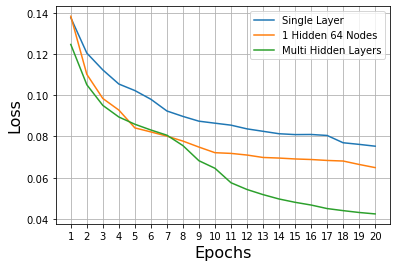

In [25]:
x = [i for i in range(1, 21)]
plt.plot(x, single_layer_loss, label = "Single Layer")
plt.plot(x, multi_layer_1_loss, label = "1 Hidden 64 Nodes")
plt.plot(x, multi_layer_2_loss, label = "Multi Hidden Layers")
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel("Loss", fontsize = 16)
plt.locator_params(axis="x", nbins=21)
plt.grid()
plt.legend(prop = {'size' : 10})
directory = r"C:\Users\PC\Documents\projects\mathProject\figures\multi_layer\Deeper.png"
plt.savefig(directory, dpi = 1400)
plt.show()

In [26]:
class multi_layer_conv:
    def __init__(self, train_df, valid_df, test_df, batch_size):
        self.train_df = train_df
        self.valid_df = valid_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.train_gen = self.train_gen = self.get_gen(self.train_df)
        self.valid_gen = self.get_gen(self.valid_df)
        self.test_gen = self.get_gen(self.test_df)
        self.model = Sequential()
        
        
        
    def get_gen(self, df):
        return ImageDataGenerator().flow_from_dataframe(
        dataframe = df,
        x_col = "directory",
        y_col = df.columns[5:],
        target_size = (28, 28),
        color_mode = "grayscale",
        class_mode = "raw",
        batch_size = self.batch_size,
        )
    
    def choose(self, item, learning_rate = 0.001):
        if item == "gradient":
            return tf.keras.optimizers.SGD(learning_rate = learning_rate)
        elif item == 'adam':
            return 'adam'
        elif item == 'binary_crossentropy':
            return 'binary_crossentropy'
        elif item == 'mean_squared_error':
            return tf.keras.losses.MeanSquaredError()

    def build_model(self, optimizer, loss, learning_rate = 0.001):
        self.model = Sequential([
            Conv2D(4, (5,5), padding = 'valid', input_shape = (28, 28, 1)),
            MaxPooling2D(),
            
            
            Conv2D(32, (3,3), padding = 'valid'),
            MaxPooling2D(),
            
            
            Flatten(),
            Dense(128, activation = 'relu'),
            Dense(64, activation = 'relu'),
    
            Dense(10, activation = 'softmax')
        ])
        
        self.model.summary()
        self.model.compile(optimizer = self.choose(optimizer, learning_rate),
                     loss = self.choose(loss),
                     metrics = [tf.keras.metrics.MeanSquaredError(), 'accuracy'])
        
    
    def train_model(self, epochs):
        ssTrain = self.train_gen.n//self.batch_size
        ssValid = self.valid_gen.n//self.batch_size
        history = self.model.fit(
            self.train_gen,
            epochs = epochs,
            steps_per_epoch = ssTrain,
            validation_steps = ssValid,
            validation_data = self.valid_gen
        )
        return history
    

In [27]:
multi_layer_conv_histories = []
for n in range(5):
    print(f"-------------------------------------------- iteration {n}------------------")
    model = multi_layer_conv(train_df, validation_df, test_df, 32)
    model.build_model("gradient", "mean_squared_error", 0.00316)
    history = model.train_model(20)
    multi_layer_conv_histories.append(history)


-------------------------------------------- iteration 0------------------
Found 34020 validated image filenames.
Found 3780 validated image filenames.
Found 4200 validated image filenames.
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 4)         104       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 32)        1184      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                             

1063/1063 [==============================] - 9s 8ms/step - loss: 0.0946 - mean_squared_error: 0.0946 - accuracy: 0.5034 - val_loss: 0.0940 - val_mean_squared_error: 0.0940 - val_accuracy: 0.5042
Epoch 4/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0905 - mean_squared_error: 0.0905 - accuracy: 0.5212 - val_loss: 0.0910 - val_mean_squared_error: 0.0910 - val_accuracy: 0.5143
Epoch 5/20
1063/1063 [==============================] - 9s 8ms/step - loss: 0.0877 - mean_squared_error: 0.0877 - accuracy: 0.5330 - val_loss: 0.0895 - val_mean_squared_error: 0.0895 - val_accuracy: 0.5233
Epoch 6/20
1063/1063 [==============================] - 9s 8ms/step - loss: 0.0856 - mean_squared_error: 0.0856 - accuracy: 0.5383 - val_loss: 0.0874 - val_mean_squared_error: 0.0874 - val_accuracy: 0.5275
Epoch 7/20
1063/1063 [==============================] - 9s 8ms/step - loss: 0.0837 - mean_squared_error: 0.0837 - accuracy: 0.5430 - val_loss: 0.0851 - val_mean_squared_error: 0.0851 - va

Epoch 14/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0426 - mean_squared_error: 0.0426 - accuracy: 0.7605 - val_loss: 0.0449 - val_mean_squared_error: 0.0449 - val_accuracy: 0.7466
Epoch 15/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0417 - mean_squared_error: 0.0417 - accuracy: 0.7632 - val_loss: 0.0447 - val_mean_squared_error: 0.0447 - val_accuracy: 0.7481
Epoch 16/20
1063/1063 [==============================] - 9s 8ms/step - loss: 0.0410 - mean_squared_error: 0.0410 - accuracy: 0.7642 - val_loss: 0.0439 - val_mean_squared_error: 0.0439 - val_accuracy: 0.7484
Epoch 17/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0403 - mean_squared_error: 0.0403 - accuracy: 0.7669 - val_loss: 0.0425 - val_mean_squared_error: 0.0425 - val_accuracy: 0.7503
Epoch 18/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0396 - mean_squared_error: 0.0396 - accuracy: 0.7676 - val_loss: 0.0423 - val_mean_squared_er

 max_pooling2d_9 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_19 (Flatten)        (None, 800)               0         
                                                                 
 dense_52 (Dense)            (None, 128)               102528    
                                                                 
 dense_53 (Dense)            (None, 64)                8256      
                                                                 
 dense_54 (Dense)            (None, 10)                650       
                                                                 
Total params: 112,722
Trainable params: 112,722
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1063/1063 [==============================] - 9s 8ms/step - loss: 0.1268 - mean_squared_error: 0.1268 - accuracy: 0.3456 - val

In [28]:
multi_layer_conv_loss = sum([np.array(history.history['val_loss']) for history in multi_layer_conv_histories])/5
multi_layer_conv_loss

array([0.10696515, 0.09640273, 0.0910259 , 0.08231387, 0.07273389,
       0.06798453, 0.06650281, 0.05930279, 0.05527768, 0.04874176,
       0.04675561, 0.04585684, 0.04299981, 0.04182321, 0.04111432,
       0.04050749, 0.03728223, 0.03403991, 0.03317453, 0.02969111])

In [29]:
multi_layer_conv_acc = sum([np.array(history.history['val_accuracy']) for history in multi_layer_conv_histories])/5
multi_layer_conv_acc

array([0.44300848, 0.49629236, 0.52134534, 0.56165252, 0.61016949,
       0.63188559, 0.63808264, 0.67309324, 0.69518009, 0.73268008,
       0.74141948, 0.74491525, 0.75895128, 0.76355931, 0.76583686,
       0.76636652, 0.78336865, 0.80153602, 0.80614407, 0.82288135])

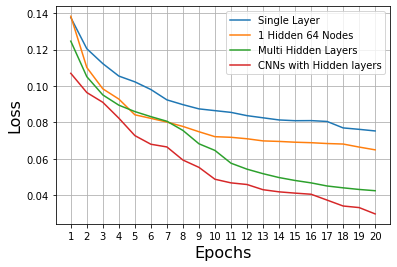

In [30]:
x = [i for i in range(1, 21)]
plt.plot(x, single_layer_loss, label = "Single Layer")
plt.plot(x, multi_layer_1_loss, label = "1 Hidden 64 Nodes")
plt.plot(x, multi_layer_2_loss, label = "Multi Hidden Layers")
plt.plot(x, multi_layer_conv_loss, label = "CNNs with Hidden layers")
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel("Loss", fontsize = 16)
plt.locator_params(axis="x", nbins=21)
plt.grid()
plt.legend(prop = {'size' : 10})
directory = r"C:\Users\PC\Documents\projects\mathProject\figures\multi_layer\conv_loss.png"
plt.savefig(directory, dpi = 1400)
plt.show()

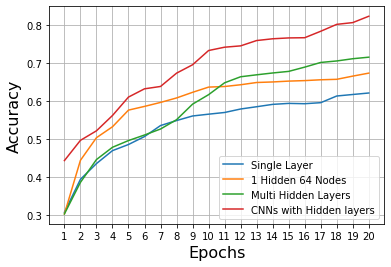

In [31]:
x = [i for i in range(1, 21)]
plt.plot(x, single_layer_acc, label = "Single Layer")
plt.plot(x, multi_layer_1_acc, label = "1 Hidden 64 Nodes")
plt.plot(x, multi_layer_2_acc, label = "Multi Hidden Layers")
plt.plot(x, multi_layer_conv_acc, label = "CNNs with Hidden layers")
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel("Accuracy", fontsize = 16)
plt.locator_params(axis="x", nbins=21)
plt.grid()
plt.legend(prop = {'size' : 10})
directory = r"C:\Users\PC\Documents\projects\mathProject\figures\multi_layer\conv_acc.png"
plt.savefig(directory, dpi = 1400)
plt.show()

In [32]:
multi_layer_conv_opt_histories = []
for n in range(5):
    print(f"--------------------------------------------iteration {n}------------------")
    model = multi_layer_conv(train_df, validation_df, test_df, 32)
    model.build_model("adam", "binary_crossentropy", 0.00316)
    history = model.train_model(20)
    multi_layer_conv_opt_histories.append(history)


--------------------------------------------iteration 0------------------
Found 34020 validated image filenames.
Found 3780 validated image filenames.
Found 4200 validated image filenames.
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 24, 24, 4)         104       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 12, 12, 4)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 10, 10, 32)        1184      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 5, 5, 32)         0         
 g2D)                                                            
                                                              

1063/1063 [==============================] - 8s 8ms/step - loss: 0.0171 - mean_squared_error: 0.0037 - accuracy: 0.9770 - val_loss: 0.0205 - val_mean_squared_error: 0.0043 - val_accuracy: 0.9759
Epoch 4/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0137 - mean_squared_error: 0.0029 - accuracy: 0.9821 - val_loss: 0.0217 - val_mean_squared_error: 0.0045 - val_accuracy: 0.9719
Epoch 5/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0121 - mean_squared_error: 0.0026 - accuracy: 0.9841 - val_loss: 0.0212 - val_mean_squared_error: 0.0048 - val_accuracy: 0.9714
Epoch 6/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0104 - mean_squared_error: 0.0024 - accuracy: 0.9852 - val_loss: 0.0200 - val_mean_squared_error: 0.0044 - val_accuracy: 0.9748
Epoch 7/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0095 - mean_squared_error: 0.0020 - accuracy: 0.9877 - val_loss: 0.0169 - val_mean_squared_error: 0.0039 - va

Epoch 14/20
1063/1063 [==============================] - 9s 8ms/step - loss: 0.0057 - mean_squared_error: 0.0013 - accuracy: 0.9927 - val_loss: 0.0134 - val_mean_squared_error: 0.0025 - val_accuracy: 0.9844
Epoch 15/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0046 - mean_squared_error: 9.8901e-04 - accuracy: 0.9940 - val_loss: 0.0181 - val_mean_squared_error: 0.0029 - val_accuracy: 0.9836
Epoch 16/20
1063/1063 [==============================] - 9s 8ms/step - loss: 0.0038 - mean_squared_error: 8.2724e-04 - accuracy: 0.9949 - val_loss: 0.0186 - val_mean_squared_error: 0.0030 - val_accuracy: 0.9836
Epoch 17/20
1063/1063 [==============================] - 8s 8ms/step - loss: 0.0055 - mean_squared_error: 0.0011 - accuracy: 0.9935 - val_loss: 0.0185 - val_mean_squared_error: 0.0031 - val_accuracy: 0.9820
Epoch 18/20
1063/1063 [==============================] - 9s 8ms/step - loss: 0.0031 - mean_squared_error: 6.7329e-04 - accuracy: 0.9961 - val_loss: 0.0189 - val_mea

                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 5, 5, 32)         0         
 g2D)                                                            
                                                                 
 flatten_24 (Flatten)        (None, 800)               0         
                                                                 
 dense_67 (Dense)            (None, 128)               102528    
                                                                 
 dense_68 (Dense)            (None, 64)                8256      
                                                                 
 dense_69 (Dense)            (None, 10)                650       
                                                                 
Total params: 112,722
Trainable params: 112,722
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1063/1063 [==============================] - 9s 8ms/step - 

In [36]:
multi_layer_conv_opt_loss = sum([np.array(history.history['mean_squared_error']) for history in multi_layer_conv_opt_histories])/5
multi_layer_conv_opt_loss

array([0.01618329, 0.0052189 , 0.00365472, 0.00305882, 0.00268919,
       0.00239778, 0.00207106, 0.00182836, 0.00160604, 0.00146599,
       0.00131575, 0.00129838, 0.00111705, 0.00110932, 0.00101286,
       0.00086322, 0.0008831 , 0.00091518, 0.0007432 , 0.00081109])

In [34]:
multi_layer_conv_opt_acc = sum([np.array(history.history['val_accuracy']) for history in multi_layer_conv_opt_histories])/5
multi_layer_conv_opt_acc

array([0.95481991, 0.96996821, 0.97658898, 0.97690678, 0.97711864,
       0.97801907, 0.97674789, 0.97913135, 0.97865465, 0.97923729,
       0.98082627, 0.98305085, 0.98241526, 0.97992586, 0.98273306,
       0.98162076, 0.98151484, 0.98146187, 0.98193858, 0.98268008])

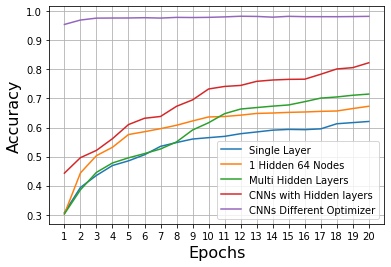

In [35]:
x = [i for i in range(1, 21)]
plt.plot(x, single_layer_acc, label = "Single Layer")
plt.plot(x, multi_layer_1_acc, label = "1 Hidden 64 Nodes")
plt.plot(x, multi_layer_2_acc, label = "Multi Hidden Layers")
plt.plot(x, multi_layer_conv_acc, label = "CNNs with Hidden layers")
plt.plot(x, multi_layer_conv_opt_acc, label = "CNNs Different Optimizer")
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel("Accuracy", fontsize = 16)
plt.locator_params(axis="x", nbins=21)
plt.grid()
plt.legend(prop = {'size' : 10})
directory = r"C:\Users\PC\Documents\projects\mathProject\figures\multi_layer\conv_opt_acc.png"
plt.savefig(directory, dpi = 1400)
plt.show()

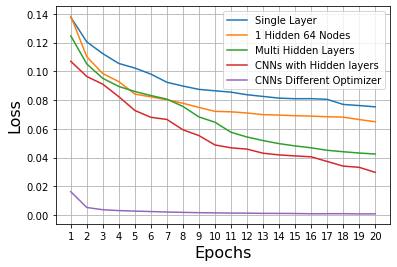

In [37]:
x = [i for i in range(1, 21)]
plt.plot(x, single_layer_loss, label = "Single Layer")
plt.plot(x, multi_layer_1_loss, label = "1 Hidden 64 Nodes")
plt.plot(x, multi_layer_2_loss, label = "Multi Hidden Layers")
plt.plot(x, multi_layer_conv_loss, label = "CNNs with Hidden layers")
plt.plot(x, multi_layer_conv_opt_loss, label = "CNNs Different Optimizer")
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel("Loss", fontsize = 16)
plt.locator_params(axis="x", nbins=21)
plt.grid()
plt.legend(prop = {'size' : 10})
directory = r"C:\Users\PC\Documents\projects\mathProject\figures\multi_layer\conv_opt_loss.png"
plt.savefig(directory, dpi = 1400)
plt.show()